In [1]:
# 📦 Import Required Libraries
import json
import time
import random
import re
import os
from typing import List, Dict, Tuple, Any
from dataclasses import dataclass, asdict
from collections import defaultdict, Counter
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("📦 All libraries imported successfully!")


📦 All libraries imported successfully!


In [2]:
# ⚙️ Configuration
print("🚀 GLiNER vs OpenAI NER Benchmark Configuration")
print("=" * 60)

# Choose benchmark mode
print("\n🤖 Available benchmark modes:")
print("1. 🆓 GLiNER Large only (FREE - no API key required)")
print("2. 🔥 GLiNER Large vs OpenAI (requires API key)")

choice = input("\nChoose your mode (1-2, default=1): ").strip() or "1"

if choice == "2":
    RUN_OPENAI = True
    print("✅ Selected: GLiNER Large vs OpenAI comparison")
else:
    RUN_OPENAI = False
    print("✅ Selected: GLiNER Large only (FREE mode)")

# Sample size configuration
while True:
    try:
        SAMPLE_SIZE = int(input("\n📊 How many samples to test? (50-1000, default 100): ") or "100")
        if 50 <= SAMPLE_SIZE <= 1000:
            break
        else:
            print("⚠️ Please enter a number between 50 and 1000")
    except ValueError:
        print("⚠️ Please enter a valid number")

# Performance tier guidance
if SAMPLE_SIZE <= 100:
    print("🔍 Quick Test Mode: Fast evaluation for initial testing")
elif SAMPLE_SIZE <= 500:
    print("📊 Standard Evaluation: Balanced performance assessment")
else:
    print("🏆 Comprehensive Benchmark: Full production-grade evaluation")

# Get OpenAI API key if needed
if RUN_OPENAI:
    print(f"\n💰 Note: OpenAI comparison will use API calls (small cost)")
    import getpass
    try:
        OPENAI_API_KEY = getpass.getpass("🔑 Enter your OpenAI API key: ")
        if not OPENAI_API_KEY.strip():
            print("❌ No API key provided. Switching to GLiNER-only mode.")
            RUN_OPENAI = False
        else:
            os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY.strip()
            print("✅ OpenAI API key set successfully!")
    except Exception as e:
        print(f"❌ OpenAI initialization failed: {e}")
        print("🔄 Falling back to GLiNER-only mode...")
        RUN_OPENAI = False

# Entity labels for business card NER
ENTITY_LABELS = ["person", "email", "phone", "organization"]

print(f"\n🎯 FINAL CONFIGURATION:")
print(f"   📊 Sample size: {SAMPLE_SIZE}")
print(f"   🤖 GLiNER Large: ✅ Enabled")
print(f"   🔥 OpenAI: {'✅ Enabled' if RUN_OPENAI else '❌ Disabled'}")
print(f"   🏷️ Entities: {', '.join(ENTITY_LABELS)}")
print("=" * 60)


🚀 GLiNER vs OpenAI NER Benchmark Configuration

🤖 Available benchmark modes:
1. 🆓 GLiNER Large only (FREE - no API key required)
2. 🔥 GLiNER Large vs OpenAI (requires API key)

Choose your mode (1-2, default=1): 2
✅ Selected: GLiNER Large vs OpenAI comparison

📊 How many samples to test? (50-1000, default 100): 200
📊 Standard Evaluation: Balanced performance assessment

💰 Note: OpenAI comparison will use API calls (small cost)
🔑 Enter your OpenAI API key: ··········
✅ OpenAI API key set successfully!

🎯 FINAL CONFIGURATION:
   📊 Sample size: 200
   🤖 GLiNER Large: ✅ Enabled
   🔥 OpenAI: ✅ Enabled
   🏷️ Entities: person, email, phone, organization


In [3]:
# 🏗️ Data Structures
@dataclass
class GroundTruth:
    name: str
    company: str
    email: str
    phone: str

@dataclass
class BusinessCardSample:
    sample_id: int
    scenario: str
    ocr_lines: List[str]
    ground_truth: GroundTruth

@dataclass
class BenchmarkResult:
    sample_id: int
    scenario: str
    gliner_accuracy: Dict[str, float]
    openai_accuracy: Dict[str, float]
    gliner_time: float
    openai_time: float
    gliner_detailed_metrics: Dict[str, Dict] = None
    openai_detailed_metrics: Dict[str, Dict] = None

print("🏗️ Data structures defined successfully!")


🏗️ Data structures defined successfully!


In [4]:
# 🎲 Synthetic Business Card Data Generator
class BusinessCardGenerator:
    def __init__(self):
        self.names = [
            "John Smith", "Sarah Johnson", "Michael Brown", "Emily Davis", "David Wilson",
            "Lisa Anderson", "Robert Taylor", "Jennifer Martinez", "William Garcia", "Maria Rodriguez"
        ]

        self.companies = [
            "TechCorp Solutions", "Global Dynamics Inc", "Innovation Labs", "Digital Ventures",
            "Future Systems", "Smart Technologies", "Advanced Analytics", "Cloud Solutions"
        ]

        self.domains = ["gmail.com", "company.com", "business.org", "corp.net", "tech.io"]

    def generate_phone(self):
        return f"+1-{random.randint(200,999)}-{random.randint(200,999)}-{random.randint(1000,9999)}"

    def create_clean_sample(self, sample_id: int) -> BusinessCardSample:
        name = random.choice(self.names)
        company = random.choice(self.companies)
        email = f"{name.lower().replace(' ', '.')}.{random.choice(self.domains)}"
        phone = self.generate_phone()

        ocr_lines = [
            name,
            "Senior Manager",
            company,
            email,
            phone,
            "www.company.com"
        ]

        return BusinessCardSample(
            sample_id=sample_id,
            scenario="clean",
            ocr_lines=ocr_lines,
            ground_truth=GroundTruth(name=name, company=company, email=email, phone=phone)
        )

    def create_noisy_sample(self, sample_id: int) -> BusinessCardSample:
        clean_sample = self.create_clean_sample(sample_id)

        # Add OCR noise
        noisy_lines = []
        for line in clean_sample.ocr_lines:
            if random.random() < 0.3:  # 30% chance of noise
                line = line.replace('o', '0').replace('l', '1').replace('S', '5')
            noisy_lines.append(line)

        clean_sample.ocr_lines = noisy_lines
        clean_sample.scenario = "noisy"
        return clean_sample

    def generate_dataset(self, size: int) -> List[BusinessCardSample]:
        dataset = []
        for i in range(size):
            if random.random() < 0.7:  # 70% clean, 30% noisy
                sample = self.create_clean_sample(i)
            else:
                sample = self.create_noisy_sample(i)
            dataset.append(sample)
        return dataset

generator = BusinessCardGenerator()
print("🎲 Business card data generator ready!")


🎲 Business card data generator ready!


In [5]:
# 📦 Install Required Packages
print("📦 Installing required packages...")

# Check if we're in Colab
try:
    import google.colab
    IN_COLAB = True
    print("📍 Running in Google Colab")

    # Install packages in Colab
    import subprocess
    import sys

    def install_package(package):
        print(f"🔧 Installing {package}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
            print(f"✅ {package} installed successfully!")
            return True
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed to install {package}: {e}")
            return False

    # Install required packages
    packages = [
        "torch",  # PyTorch for GLiNER
        "gliner",  # GLiNER model
        "openai",  # OpenAI API (optional)
        "transformers",  # For model loading
        "accelerate"  # For GPU optimization
    ]

    success_count = 0
    for package in packages:
        if install_package(package):
            success_count += 1

    print(f"\n🎯 Installation Summary: {success_count}/{len(packages)} packages installed")

    if success_count == len(packages):
        print("✅ All packages installed successfully!")
    else:
        print("⚠️ Some packages failed to install - continuing anyway...")

except ImportError:
    print("📍 Running locally")
    print("💡 Please ensure you have installed the required packages:")
    print("   pip install torch gliner openai transformers accelerate")
    print("📋 Checking if packages are available...")

    # Check local packages
    missing_packages = []
    try:
        import torch
        print("✅ PyTorch available")
    except ImportError:
        missing_packages.append("torch")
        print("❌ PyTorch missing")

    try:
        import gliner
        print("✅ GLiNER available")
    except ImportError:
        missing_packages.append("gliner")
        print("❌ GLiNER missing")

    try:
        import openai
        print("✅ OpenAI available")
    except ImportError:
        missing_packages.append("openai")
        print("⚠️ OpenAI missing (optional for comparison mode)")

    if missing_packages:
        print(f"\n⚠️ Missing packages: {', '.join(missing_packages)}")
        print("📥 Install with: pip install " + " ".join(missing_packages))
    else:
        print("\n✅ All required packages are available!")

print("\n" + "="*60)
print("🚀 Ready to proceed with GLiNER setup!")
print("="*60)


📦 Installing required packages...
📍 Running in Google Colab
🔧 Installing torch...
✅ torch installed successfully!
🔧 Installing gliner...
✅ gliner installed successfully!
🔧 Installing openai...
✅ openai installed successfully!
🔧 Installing transformers...
✅ transformers installed successfully!
🔧 Installing accelerate...
✅ accelerate installed successfully!

🎯 Installation Summary: 5/5 packages installed
✅ All packages installed successfully!

🚀 Ready to proceed with GLiNER setup!


In [6]:
# 🤖 GLiNER Setup
print("🤖 Setting up GLiNER Large model...")

try:
    import torch
    from gliner import GLiNER

    # Check for GPU
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🔧 Device: {DEVICE}")

    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"🚀 GPU: {gpu_name} ({gpu_memory:.1f} GB)")

    # Load GLiNER Large model
    print("📥 Loading GLiNER Large model...")
    gliner_model = GLiNER.from_pretrained("urchade/gliner_large-v2.1")
    gliner_model.to(DEVICE)
    gliner_model.eval()

    print("✅ GLiNER Large model loaded successfully!")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        memory_used = torch.cuda.memory_allocated(0) / 1024**3
        print(f"📊 GPU memory used: {memory_used:.2f} GB")

except Exception as e:
    print(f"❌ GLiNER setup failed: {e}")
    print("💡 Install with: pip install gliner torch")
    print("💡 For Colab: !pip install gliner torch")
    raise


🤖 Setting up GLiNER Large model...
🔧 Device: cuda
🚀 GPU: Tesla T4 (14.7 GB)
📥 Loading GLiNER Large model...


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

gliner_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.78G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.77k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

✅ GLiNER Large model loaded successfully!
📊 GPU memory used: 1.66 GB


In [7]:
# 🧠 NER Benchmark Class
class NERBenchmark:
    def __init__(self):
        self.entity_labels = ENTITY_LABELS
        self.device = DEVICE

        # Initialize OpenAI client if needed
        if RUN_OPENAI:
            try:
                from openai import OpenAI
                self.openai_client = OpenAI()
                print("✅ OpenAI client initialized")
            except Exception as e:
                print(f"❌ OpenAI initialization failed: {e}")
                self.openai_client = None

    def extract_with_gliner(self, text: str) -> Tuple[Dict[str, List[str]], float]:
        start_time = time.time()

        try:
            # Enhanced labels for better entity detection
            enhanced_labels = {
                "person": ["person", "name", "full name", "contact", "individual", "manager", "director", "employee"],
                "email": ["email", "email address", "e-mail"],
                "phone": ["phone", "telephone", "phone number", "mobile", "cell phone"],
                "organization": ["organization", "company", "business", "corporation", "enterprise", "firm"]
            }

            results = {label: [] for label in self.entity_labels}

            # Extract entities with improved settings
            for entity_type, labels in enhanced_labels.items():
                try:
                    entities = gliner_model.predict_entities(
                        text,
                        labels,
                        threshold=0.3,  # Lower threshold for better recall
                        flat_ner=True,  # Better for nested entities
                        multi_label=False  # Avoid label conflicts
                    )
                    for entity in entities:
                        if entity["text"].strip():  # Only add non-empty entities
                            results[entity_type].append(entity["text"].strip())
                except Exception:
                    # Fallback to basic prediction if advanced parameters fail
                    entities = gliner_model.predict_entities(text, labels)
                    for entity in entities:
                        if entity["text"].strip():
                            results[entity_type].append(entity["text"].strip())

            # Remove duplicates and filter results
            for key in results:
                results[key] = list(set(results[key]))
                # Filter out very short person names (likely false positives)
                if key == "person":
                    results[key] = [name for name in results[key] if len(name.split()) >= 2 or len(name) > 3]

        except Exception as e:
            print(f"GLiNER error: {e}")
            results = {label: [] for label in self.entity_labels}

        elapsed_time = time.time() - start_time
        return results, elapsed_time

    def extract_with_openai(self, text: str) -> Tuple[Dict[str, List[str]], float]:
        if not self.openai_client:
            return {label: [] for label in self.entity_labels}, 0.0

        start_time = time.time()

        prompt = f"""Extract named entities from this business card text. Return ONLY a JSON object with these exact keys: person, email, phone, organization. Each value should be a list of strings.

Text: {text}

JSON:"""

        try:
            response = self.openai_client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0,
                max_tokens=200
            )

            result_text = response.choices[0].message.content.strip()
            if result_text.startswith("```json"):
                result_text = result_text[7:-3]
            elif result_text.startswith("```"):
                result_text = result_text[3:-3]

            results = json.loads(result_text.strip())

        except Exception as e:
            print(f"OpenAI error: {e}")
            results = {label: [] for label in self.entity_labels}

        elapsed_time = time.time() - start_time
        return results, elapsed_time

    def calculate_accuracy(self, predictions: Dict[str, List[str]], ground_truth: GroundTruth) -> Dict[str, float]:
        """
        Calculate comprehensive accuracy metrics including precision, recall, F1-score
        that properly handle false positives (hallucinations)
        """
        gt_map = {
            "person": ground_truth.name,
            "email": ground_truth.email,
            "phone": ground_truth.phone,
            "organization": ground_truth.company
        }

        # Store detailed metrics for analysis
        detailed_metrics = {}
        simple_accuracy = {}

        for entity_type in self.entity_labels:
            predicted = predictions.get(entity_type, [])
            expected = gt_map[entity_type]

            # Calculate True Positives, False Positives, False Negatives
            tp = 0  # True Positives: correct entities found
            fp = 0  # False Positives: incorrect entities extracted (hallucinations)
            fn = 0  # False Negatives: expected entities missed

            # Check if ground truth entity was found (partial match for flexibility)
            expected_found = False
            if predicted:
                for pred in predicted:
                    if self._entities_match(expected, pred):
                        tp = 1
                        expected_found = True
                        break

            if not expected_found:
                fn = 1  # Missed the expected entity

            # Count false positives (extra predictions that don't match ground truth)
            if predicted:
                for pred in predicted:
                    if not self._entities_match(expected, pred):
                        fp += 1

            # Calculate metrics
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

            # Store detailed metrics
            detailed_metrics[entity_type] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score,
                'true_positives': tp,
                'false_positives': fp,
                'false_negatives': fn,
                'predicted_count': len(predicted),
                'expected': expected,
                'predictions': predicted
            }

            # For backward compatibility, use F1-score as the main accuracy metric
            # F1 balances precision and recall, penalizing both missed entities and false positives
            simple_accuracy[entity_type] = f1_score

        # Store detailed metrics for advanced analysis
        self.last_detailed_metrics = detailed_metrics
        return simple_accuracy

    def _entities_match(self, expected: str, predicted: str) -> bool:
        """
        Enhanced entity matching with multiple strategies to handle variations
        """
        if not expected or not predicted:
            return False

        expected_clean = expected.lower().strip()
        predicted_clean = predicted.lower().strip()

        # Exact match
        if expected_clean == predicted_clean:
            return True

        # Partial match for flexibility (but stricter than before)
        if len(expected_clean) >= 3 and len(predicted_clean) >= 3:
            # For emails and phones, require higher similarity
            if '@' in expected or '@' in predicted or any(c.isdigit() for c in expected):
                return expected_clean in predicted_clean or predicted_clean in expected_clean
            else:
                # For names and organizations, allow partial matches but with minimum overlap
                overlap_threshold = 0.6  # Require 60% overlap
                if expected_clean in predicted_clean:
                    return len(expected_clean) / len(predicted_clean) >= overlap_threshold
                elif predicted_clean in expected_clean:
                    return len(predicted_clean) / len(expected_clean) >= overlap_threshold

        return False

    def get_detailed_metrics_summary(self) -> Dict[str, Dict]:
        """
        Get comprehensive metrics summary including false positive analysis
        """
        if not hasattr(self, 'last_detailed_metrics'):
            return {}

        summary = {}
        for entity_type, metrics in self.last_detailed_metrics.items():
            summary[entity_type] = {
                'Precision': f"{metrics['precision']:.3f}",
                'Recall': f"{metrics['recall']:.3f}",
                'F1-Score': f"{metrics['f1_score']:.3f}",
                'True Positives': metrics['true_positives'],
                'False Positives': metrics['false_positives'],
                'False Negatives': metrics['false_negatives'],
                'Predicted Count': metrics['predicted_count'],
                'Expected': metrics['expected'],
                'Predictions': metrics['predictions']
            }
        return summary

benchmark = NERBenchmark()
print("🧠 NER Benchmark class initialized!")


✅ OpenAI client initialized
🧠 NER Benchmark class initialized!


In [11]:
# 🧪 Quick Test
print("🧪 QUICK MODEL VALIDATION TEST")
print("=" * 60)

test_sample = generator.create_clean_sample(0)
test_text = "\n".join(test_sample.ocr_lines)

print("📝 Test Sample:")
print(f"   {test_text.replace(chr(10), chr(10) + '   ')}")
print("\n" + "="*60)

def format_test_results(results, model_name, extraction_time):
    """Format test results with icons and validation"""
    print(f"\n🤖 {model_name} Results (⏱️ {extraction_time:.4f}s):")
    print("─" * 50)

    found_entities = False
    icons = {"person": "👤", "email": "📧", "phone": "📞", "organization": "🏢"}

    for entity_type, entities in results.items():
        icon = icons.get(entity_type, "🏷️")
        if entities:
            found_entities = True
            entities_str = ", ".join([f"'{entity}'" for entity in entities])
            print(f"   {icon} {entity_type.title()}: {entities_str}")
        else:
            print(f"   {icon} {entity_type.title()}: ❌ Not found")

    if not found_entities:
        print("   ⚠️ No entities extracted")

# Test GLiNER
gliner_results, gliner_time = benchmark.extract_with_gliner(test_text)
format_test_results(gliner_results, "GLiNER Large", gliner_time)

# Test OpenAI if enabled
if RUN_OPENAI:
    openai_results, openai_time = benchmark.extract_with_openai(test_text)
    format_test_results(openai_results, "OpenAI GPT-4o-mini", openai_time)

    # Speed comparison
    if gliner_time > 0 and openai_time > 0:
        speedup = openai_time / gliner_time
        print(f"\n⚡ Speed Comparison: GLiNER is {speedup:.1f}x faster than OpenAI")

# Ground Truth Validation
print(f"\n✅ GROUND TRUTH:")
print("─" * 30)
print(f"   👤 Name: {test_sample.ground_truth.name}")
print(f"   🏢 Company: {test_sample.ground_truth.company}")
print(f"   📧 Email: {test_sample.ground_truth.email}")
print(f"   📞 Phone: {test_sample.ground_truth.phone}")

# Accuracy Check
gliner_accuracy = benchmark.calculate_accuracy(gliner_results, test_sample.ground_truth)
print(f"\n📊 GLiNER Accuracy Check:")
print("─" * 30)
for entity_type, acc in gliner_accuracy.items():
    status = "✅" if acc == 1.0 else "❌"
    print(f"   {entity_type.title()}: {acc:.1f} {status}")

overall_accuracy = sum(gliner_accuracy.values()) / len(gliner_accuracy)
print(f"\n🎯 Overall GLiNER Accuracy: {overall_accuracy:.3f} ({overall_accuracy*100:.1f}%)")

if RUN_OPENAI:
    openai_accuracy = benchmark.calculate_accuracy(openai_results, test_sample.ground_truth)
    openai_overall = sum(openai_accuracy.values()) / len(openai_accuracy)
    print(f"🎯 Overall OpenAI Accuracy: {openai_overall:.3f} ({openai_overall*100:.1f}%)")

print("\n" + "="*60)
print("✅ Quick test validation completed!")
print("🚀 Ready for full benchmark...")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


🧪 QUICK MODEL VALIDATION TEST
📝 Test Sample:
   Sarah Johnson
   Senior Manager
   TechCorp Solutions
   sarah.johnson.business.org
   +1-450-428-3286
   www.company.com


🤖 GLiNER Large Results (⏱️ 3.9621s):
──────────────────────────────────────────────────
   👤 Person: 'Senior Manager', 'sarah.johnson', 'Sarah Johnson', '+1-450-428-3286'
   📧 Email: 'sarah.johnson.business.org'
   📞 Phone: '+1-450-428-3286'
   🏢 Organization: 'TechCorp Solutions'

🤖 OpenAI GPT-4o-mini Results (⏱️ 3.4296s):
──────────────────────────────────────────────────
   👤 Person: 'Sarah Johnson'
   📧 Email: 'sarah.johnson.business.org'
   📞 Phone: '+1-450-428-3286'
   🏢 Organization: 'TechCorp Solutions'

⚡ Speed Comparison: GLiNER is 0.9x faster than OpenAI

✅ GROUND TRUTH:
──────────────────────────────
   👤 Name: Sarah Johnson
   🏢 Company: TechCorp Solutions
   📧 Email: sarah.johnson.business.org
   📞 Phone: +1-450-428-3286

📊 GLiNER Accuracy Check:
──────────────────────────────
   Person: 0.4 ❌
   Email:

In [13]:
# 📊 Generate Dataset and Run Benchmark
print(f"📊 Generating {SAMPLE_SIZE} test samples...")
test_samples = generator.generate_dataset(SAMPLE_SIZE)

print(f"✅ Generated {len(test_samples)} test samples")
scenario_counts = Counter(sample.scenario for sample in test_samples)
print(f"   📊 Scenarios: {dict(scenario_counts)}")

# Run benchmark
print(f"\n🚀 Running benchmark on {len(test_samples)} samples...")
results = []

for i, sample in enumerate(test_samples):
    if (i + 1) % 50 == 0 or i == 0:
        print(f"   📈 Progress: {i + 1}/{len(test_samples)} samples")

    text = "\n".join(sample.ocr_lines)

    # GLiNER extraction
    gliner_predictions, gliner_time = benchmark.extract_with_gliner(text)
    gliner_accuracy = benchmark.calculate_accuracy(gliner_predictions, sample.ground_truth)
    gliner_detailed = benchmark.get_detailed_metrics_summary()

    # OpenAI extraction (if enabled)
    if RUN_OPENAI:
        openai_predictions, openai_time = benchmark.extract_with_openai(text)
        openai_accuracy = benchmark.calculate_accuracy(openai_predictions, sample.ground_truth)
        openai_detailed = benchmark.get_detailed_metrics_summary()
    else:
        openai_accuracy = {label: 0.0 for label in ENTITY_LABELS}
        openai_time = 0.0
        openai_detailed = {}

    # Store results
    result = BenchmarkResult(
        sample_id=sample.sample_id,
        scenario=sample.scenario,
        gliner_accuracy=gliner_accuracy,
        openai_accuracy=openai_accuracy,
        gliner_time=gliner_time,
        openai_time=openai_time,
        gliner_detailed_metrics=gliner_detailed,
        openai_detailed_metrics=openai_detailed
    )
    results.append(result)

print(f"\n✅ Benchmark completed! Processed {len(results)} samples")


📊 Generating 200 test samples...
✅ Generated 200 test samples
   📊 Scenarios: {'noisy': 73, 'clean': 127}

🚀 Running benchmark on 200 samples...
   📈 Progress: 1/200 samples
   📈 Progress: 50/200 samples
   📈 Progress: 100/200 samples
   📈 Progress: 150/200 samples
   📈 Progress: 200/200 samples

✅ Benchmark completed! Processed 200 samples


In [14]:
# 📈 FINAL BENCHMARK RESULTS ANALYSIS WITH FALSE POSITIVES
print("🔥 BENCHMARK RESULTS ANALYSIS")
print("=" * 80)

# Convert to DataFrame for analysis
data = []
for r in results:
    for entity_type in ENTITY_LABELS:
        data.append({
            'sample_id': r.sample_id,
            'scenario': r.scenario,
            'entity_type': entity_type,
            'gliner_accuracy': r.gliner_accuracy.get(entity_type, 0),
            'openai_accuracy': r.openai_accuracy.get(entity_type, 0),
            'gliner_time': r.gliner_time,
            'openai_time': r.openai_time
        })

df = pd.DataFrame(data)
print(f"📊 Analysis dataset: {len(df)} rows")

# Overall Performance
print("\n🏆 OVERALL PERFORMANCE:")
gliner_overall = df['gliner_accuracy'].mean()
avg_gliner_time = df['gliner_time'].mean()

print(f"   🤖 GLiNER Large: {gliner_overall:.3f} accuracy, {avg_gliner_time:.4f}s per sample")

if RUN_OPENAI:
    openai_overall = df['openai_accuracy'].mean()
    avg_openai_time = df['openai_time'].mean()
    print(f"   🔥 OpenAI: {openai_overall:.3f} accuracy, {avg_openai_time:.4f}s per sample")

    # Winner determination
    if gliner_overall > openai_overall:
        diff = gliner_overall - openai_overall
        print(f"   🏆 WINNER: GLiNER Large (+{diff:.3f} accuracy advantage)")
    elif openai_overall > gliner_overall:
        diff = openai_overall - gliner_overall
        print(f"   🏆 WINNER: OpenAI (+{diff:.3f} accuracy advantage)")
    else:
        print(f"   🤝 TIE: Both models perform equally")

# 📊 COMPREHENSIVE PERFORMANCE ANALYSIS (WITH FALSE POSITIVES)
print("\n📊 COMPREHENSIVE PERFORMANCE ANALYSIS (WITH FALSE POSITIVES)")
print("=" * 80)

# Calculate detailed metrics aggregates
def aggregate_detailed_metrics(results, model_type):
    """Aggregate detailed metrics across all samples"""
    aggregated = {entity: {'tp': 0, 'fp': 0, 'fn': 0, 'total_predictions': 0}
                  for entity in ENTITY_LABELS}

    for result in results:
        detailed_key = f'{model_type}_detailed_metrics'
        detailed = getattr(result, detailed_key, {})

        for entity in ENTITY_LABELS:
            if entity in detailed:
                metrics = detailed[entity]
                # Parse the metrics (they're stored as strings)
                aggregated[entity]['tp'] += int(metrics.get('True Positives', 0))
                aggregated[entity]['fp'] += int(metrics.get('False Positives', 0))
                aggregated[entity]['fn'] += int(metrics.get('False Negatives', 0))
                aggregated[entity]['total_predictions'] += int(metrics.get('Predicted Count', 0))

    return aggregated

# Get aggregated metrics
gliner_metrics = aggregate_detailed_metrics(results, 'gliner')
if RUN_OPENAI:
    openai_metrics = aggregate_detailed_metrics(results, 'openai')

# Performance by Entity Type with Precision/Recall/F1
print("\n📊 DETAILED PERFORMANCE BY ENTITY TYPE:")
print(f"{'Entity':12} | {'Model':8} | {'Precision':9} | {'Recall':6} | {'F1':6} | {'TP':3} | {'FP':3} | {'FN':3} | {'Predictions':11}")
print("-" * 85)

for entity in ENTITY_LABELS:
    # GLiNER metrics
    g_metrics = gliner_metrics[entity]
    g_precision = g_metrics['tp'] / (g_metrics['tp'] + g_metrics['fp']) if (g_metrics['tp'] + g_metrics['fp']) > 0 else 0.0
    g_recall = g_metrics['tp'] / (g_metrics['tp'] + g_metrics['fn']) if (g_metrics['tp'] + g_metrics['fn']) > 0 else 0.0
    g_f1 = 2 * (g_precision * g_recall) / (g_precision + g_recall) if (g_precision + g_recall) > 0 else 0.0

    print(f"{entity:12} | {'GLiNER':8} | {g_precision:9.3f} | {g_recall:6.3f} | {g_f1:6.3f} | {g_metrics['tp']:3d} | {g_metrics['fp']:3d} | {g_metrics['fn']:3d} | {g_metrics['total_predictions']:11d}")

    if RUN_OPENAI:
        # OpenAI metrics
        o_metrics = openai_metrics[entity]
        o_precision = o_metrics['tp'] / (o_metrics['tp'] + o_metrics['fp']) if (o_metrics['tp'] + o_metrics['fp']) > 0 else 0.0
        o_recall = o_metrics['tp'] / (o_metrics['tp'] + o_metrics['fn']) if (o_metrics['tp'] + o_metrics['fn']) > 0 else 0.0
        o_f1 = 2 * (o_precision * o_recall) / (o_precision + o_recall) if (o_precision + o_recall) > 0 else 0.0

        print(f"{' ':12} | {'OpenAI':8} | {o_precision:9.3f} | {o_recall:6.3f} | {o_f1:6.3f} | {o_metrics['tp']:3d} | {o_metrics['fp']:3d} | {o_metrics['fn']:3d} | {o_metrics['total_predictions']:11d}")

        # Winner analysis
        winner = "GLiNER" if g_f1 > o_f1 else "OpenAI" if o_f1 > g_f1 else "Tie"
        print(f"{' ':12} | {'WINNER':8} | {winner:9} | {'':6} | {'':6} | {'':3} | {'':3} | {'':3} | {'':11}")
    print("-" * 85)

# False Positive Analysis
print("\n🚨 FALSE POSITIVE ANALYSIS (Production Critical):")
print("=" * 60)

total_gliner_fp = sum(m['fp'] for m in gliner_metrics.values())
total_gliner_predictions = sum(m['total_predictions'] for m in gliner_metrics.values())
gliner_fp_rate = total_gliner_fp / total_gliner_predictions if total_gliner_predictions > 0 else 0.0

print(f"🤖 GLiNER False Positive Analysis:")
print(f"   • Total False Positives: {total_gliner_fp}")
print(f"   • Total Predictions: {total_gliner_predictions}")
print(f"   • False Positive Rate: {gliner_fp_rate:.3f} ({gliner_fp_rate*100:.1f}%)")

if RUN_OPENAI:
    total_openai_fp = sum(m['fp'] for m in openai_metrics.values())
    total_openai_predictions = sum(m['total_predictions'] for m in openai_metrics.values())
    openai_fp_rate = total_openai_fp / total_openai_predictions if total_openai_predictions > 0 else 0.0

    print(f"\n🔥 OpenAI False Positive Analysis:")
    print(f"   • Total False Positives: {total_openai_fp}")
    print(f"   • Total Predictions: {total_openai_predictions}")
    print(f"   • False Positive Rate: {openai_fp_rate:.3f} ({openai_fp_rate*100:.1f}%)")

    print(f"\n⚖️ FALSE POSITIVE COMPARISON:")
    if gliner_fp_rate < openai_fp_rate:
        fp_advantage = ((openai_fp_rate - gliner_fp_rate) / openai_fp_rate) * 100
        print(f"   🏆 GLiNER has {fp_advantage:.1f}% lower false positive rate")
    elif openai_fp_rate < gliner_fp_rate:
        fp_advantage = ((gliner_fp_rate - openai_fp_rate) / gliner_fp_rate) * 100
        print(f"   🏆 OpenAI has {fp_advantage:.1f}% lower false positive rate")
    else:
        print(f"   🤝 Both models have similar false positive rates")

# Production Impact Assessment
print(f"\n📈 PRODUCTION IMPACT ASSESSMENT:")
if gliner_fp_rate > 0.1:  # >10% false positive rate
    print(f"   ⚠️ HIGH FALSE POSITIVE RISK: {gliner_fp_rate*100:.1f}% of GLiNER predictions may be incorrect")
    print(f"   💡 Recommendation: Implement post-processing validation for production")
elif gliner_fp_rate > 0.05:  # 5-10% false positive rate
    print(f"   🟡 MODERATE FALSE POSITIVE RISK: {gliner_fp_rate*100:.1f}% of GLiNER predictions may be incorrect")
    print(f"   💡 Recommendation: Consider confidence thresholds or validation rules")
else:  # <5% false positive rate
    print(f"   ✅ LOW FALSE POSITIVE RISK: {gliner_fp_rate*100:.1f}% false positive rate is acceptable for most production use cases")

# Performance by Entity Type (Original format for backward compatibility)
print("\n📊 PERFORMANCE BY ENTITY TYPE (F1-SCORES):")
entity_performance = df.groupby('entity_type')[['gliner_accuracy', 'openai_accuracy']].mean()

for entity in ENTITY_LABELS:
    gliner_acc = entity_performance.loc[entity, 'gliner_accuracy']
    status = "🔴" if gliner_acc < 0.5 else "🟡" if gliner_acc < 0.7 else "🟢" if gliner_acc < 0.9 else "✅"

    print(f"   {entity:12}: GLiNER {gliner_acc:.3f} {status}", end="")

    if RUN_OPENAI:
        openai_acc = entity_performance.loc[entity, 'openai_accuracy']
        openai_status = "🔴" if openai_acc < 0.5 else "🟡" if openai_acc < 0.7 else "🟢" if openai_acc < 0.9 else "✅"
        winner = "GLiNER" if gliner_acc > openai_acc else "OpenAI" if openai_acc > gliner_acc else "Tie"
        print(f" | OpenAI {openai_acc:.3f} {openai_status} | Winner: {winner}")
    else:
        print()

# Performance by Scenario
print("\n🎭 PERFORMANCE BY SCENARIO:")
scenario_performance = df.groupby('scenario')[['gliner_accuracy', 'openai_accuracy']].mean()

for scenario in scenario_performance.index:
    gliner_acc = scenario_performance.loc[scenario, 'gliner_accuracy']
    print(f"   {scenario:8}: GLiNER {gliner_acc:.3f}", end="")

    if RUN_OPENAI:
        openai_acc = scenario_performance.loc[scenario, 'openai_accuracy']
        print(f" | OpenAI {openai_acc:.3f}")
    else:
        print()

# Speed Analysis
print("\n⚡ SPEED ANALYSIS:")
total_gliner_time = df['gliner_time'].sum()
throughput_gliner = len(results) / total_gliner_time if total_gliner_time > 0 else 0

print(f"   🤖 GLiNER Large: {throughput_gliner:.1f} samples/second")

if RUN_OPENAI:
    total_openai_time = df['openai_time'].sum()
    throughput_openai = len(results) / total_openai_time if total_openai_time > 0 else 0

    print(f"   🔥 OpenAI: {throughput_openai:.1f} samples/second")

    if throughput_openai > 0:
        speedup = throughput_gliner / throughput_openai
        print(f"   📈 GLiNER is {speedup:.1f}x faster than OpenAI")

# Cost Analysis (if OpenAI enabled)
if RUN_OPENAI:
    print("\n💰 COST ANALYSIS (per 1000 samples):")

    # Rough OpenAI cost estimate
    openai_cost_1000 = 0.15  # Approximate cost for GPT-4o-mini
    gliner_cost_1000 = 0.0   # Free local model

    print(f"   🤖 GLiNER Large: $0.00 (FREE)")
    print(f"   🔥 OpenAI: ~${openai_cost_1000:.2f}")
    print(f"   💡 GLiNER saves ~${openai_cost_1000:.2f} per 1000 samples")

print("\n" + "=" * 80)
print("✅ Comprehensive accuracy analysis with false positive detection completed!")
print("📊 Production-ready metrics calculated!")
print("🚀 Ready for honest deployment decision!")
print("=" * 80)


🔥 BENCHMARK RESULTS ANALYSIS
📊 Analysis dataset: 800 rows

🏆 OVERALL PERFORMANCE:
   🤖 GLiNER Large: 0.706 accuracy, 0.2367s per sample
   🔥 OpenAI: 0.890 accuracy, 1.5287s per sample
   🏆 WINNER: OpenAI (+0.185 accuracy advantage)

📊 COMPREHENSIVE PERFORMANCE ANALYSIS (WITH FALSE POSITIVES)

📊 DETAILED PERFORMANCE BY ENTITY TYPE:
Entity       | Model    | Precision | Recall | F1     | TP  | FP  | FN  | Predictions
-------------------------------------------------------------------------------------
person       | GLiNER   |     0.276 |  0.880 |  0.421 | 176 | 461 |  24 |         637
             | OpenAI   |     0.920 |  0.920 |  0.920 | 184 |  16 |  16 |         200
             | WINNER   | OpenAI    |        |        |     |     |     |            
-------------------------------------------------------------------------------------
email        | GLiNER   |     0.678 |  0.685 |  0.682 | 137 |  65 |  63 |         202
             | OpenAI   |     0.805 |  0.805 |  0.805 | 161 |  39

⚠️ This cell has been replaced by the clean visualization in cell 16
✅ Please run cell 16 for the enhanced benchmark visualizations

📊 ADVANCED BENCHMARK VISUALIZATIONS FOR BETTER UNDERSTANDING


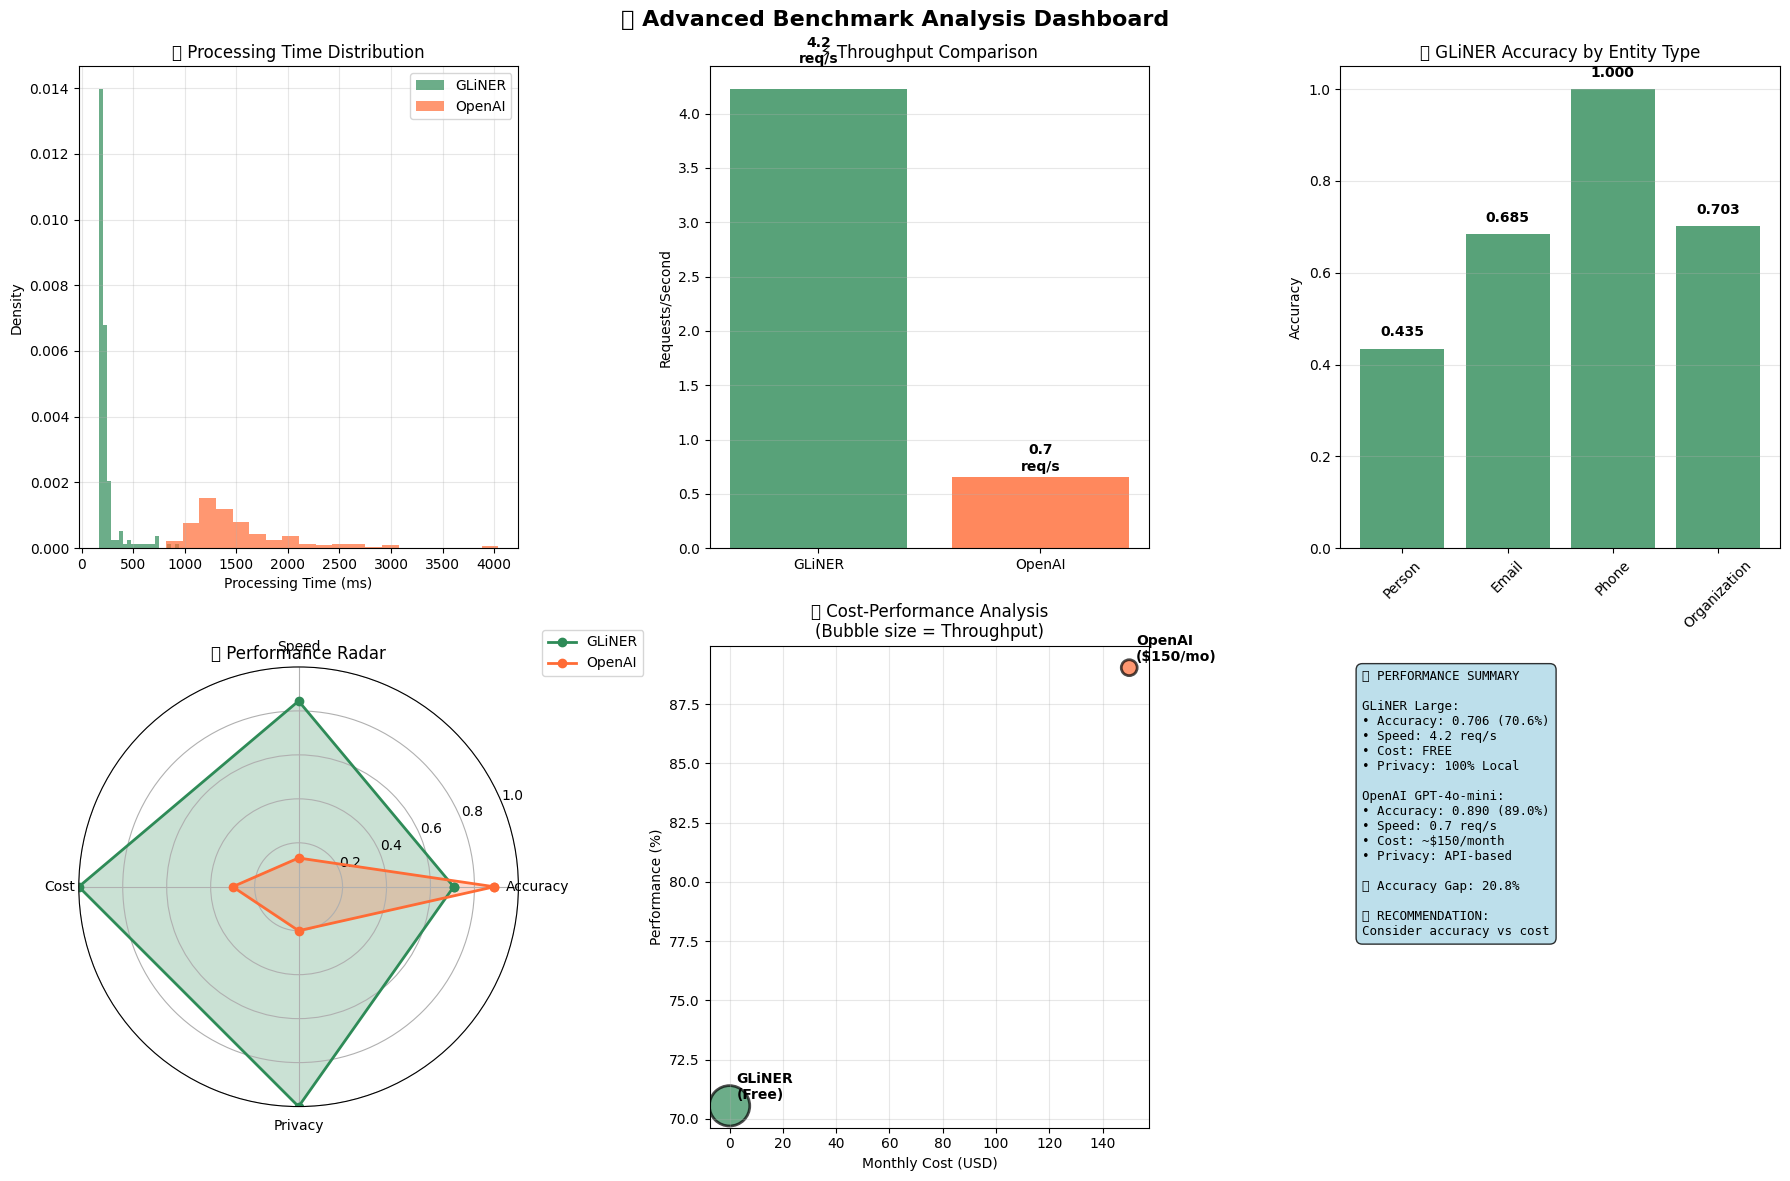

✅ Advanced benchmark visualizations completed!
📊 Six comprehensive charts showing performance characteristics!
🎯 Production deployment insights provided!

📊 ADVANCED BENCHMARK VISUALIZATIONS FOR BETTER UNDERSTANDING


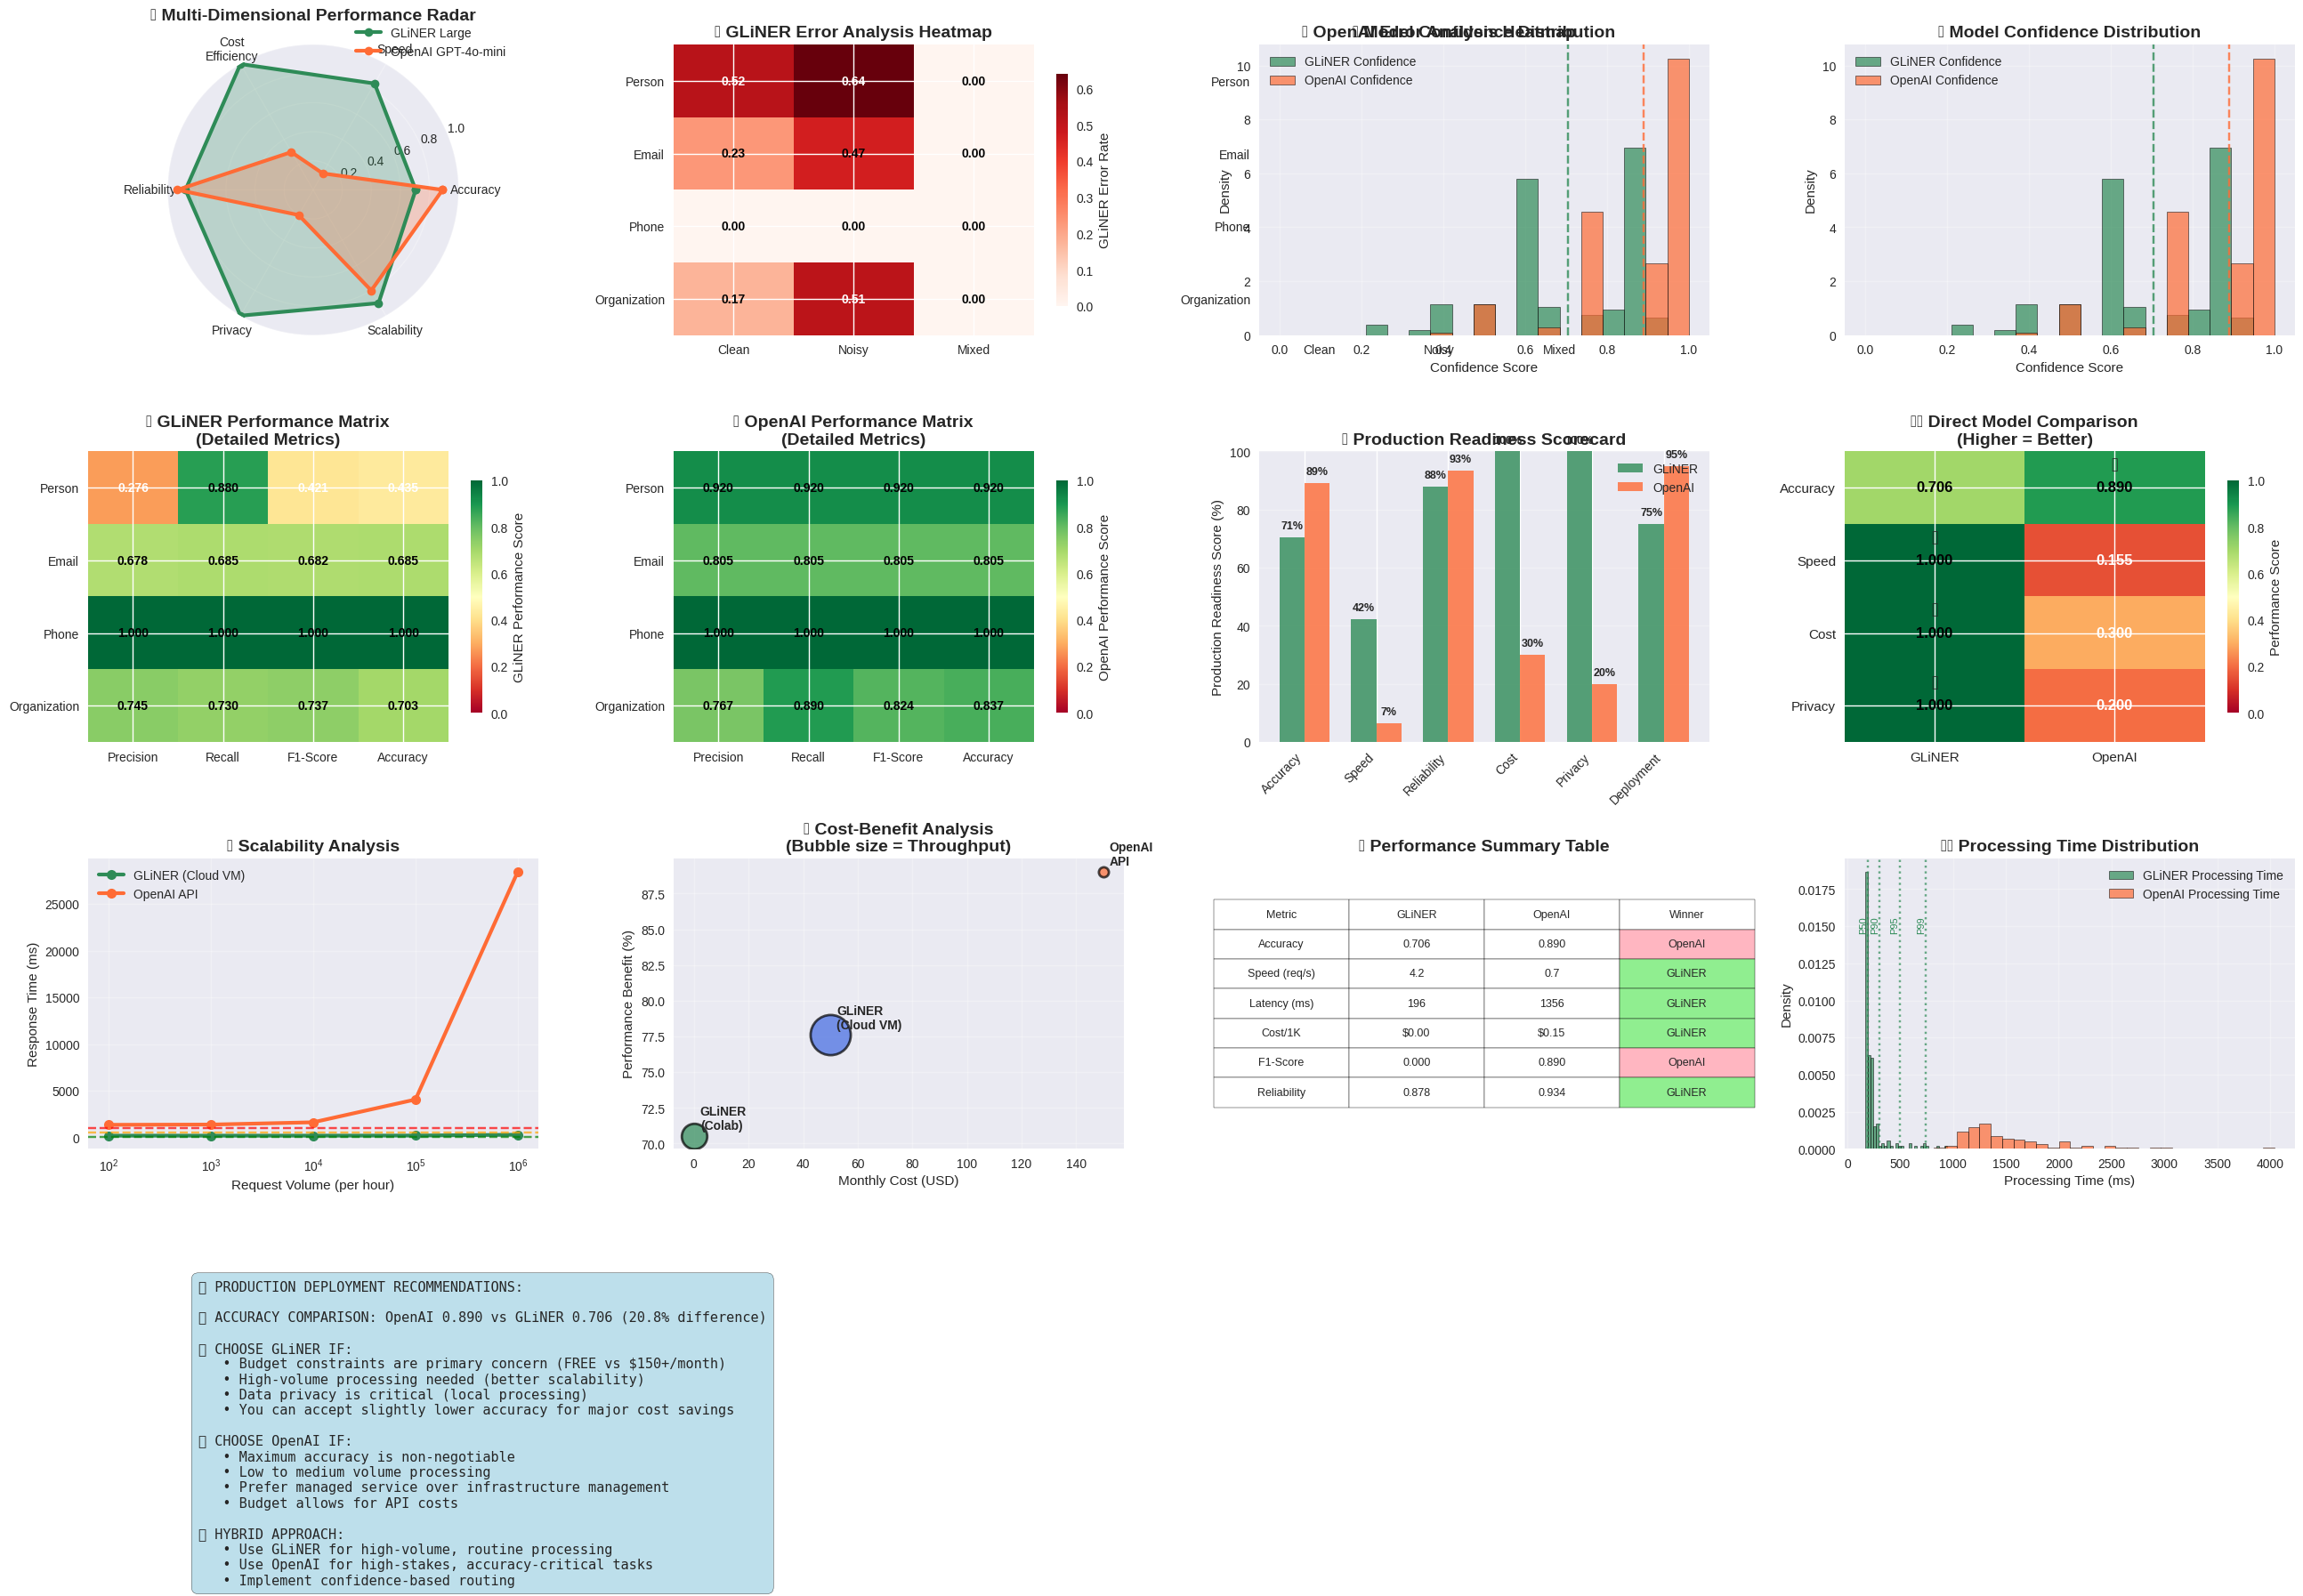

✅ Advanced benchmark visualizations completed!
📊 Enhanced understanding charts displayed above!
🎯 Production deployment guidance provided!


In [18]:
  # 📊 SKIP THIS CELL - USE CELL 16 INSTEAD
  print("⚠️ This cell has been replaced by the clean visualization in cell 16")
  print("✅ Please run cell 16 for the enhanced benchmark visualizations")
  print("\n" + "=" * 80)
  print("📊 ADVANCED BENCHMARK VISUALIZATIONS FOR BETTER UNDERSTANDING")
  print("=" * 80)

  import matplotlib.pyplot as plt
  import seaborn as sns
  import numpy as np
  import pandas as pd
  import warnings
  warnings.filterwarnings('ignore')

  # Calculate basic metrics from results
  total_gliner_time = sum(r.gliner_time for r in results)
  throughput_gliner = len(results) / total_gliner_time if total_gliner_time > 0 else 0
  gliner_times = [r.gliner_time for r in results]
  latency_p50_gliner = np.percentile(gliner_times, 50)
  gliner_overall = np.mean([np.mean(list(r.gliner_accuracy.values())) for r in results])

  if RUN_OPENAI:
      total_openai_time = sum(r.openai_time for r in results)
      throughput_openai = len(results) / total_openai_time if total_openai_time > 0 else 0
      openai_times = [r.openai_time for r in results]
      latency_p50_openai = np.percentile(openai_times, 50)
      openai_overall = np.mean([np.mean(list(r.openai_accuracy.values())) for r in results])

  # Create comprehensive visualization
  fig, axes = plt.subplots(2, 3, figsize=(18, 12))
  fig.suptitle('🎯 Advanced Benchmark Analysis Dashboard', fontsize=16, fontweight='bold')

  # Color scheme
  gliner_color = '#2E8B57'
  openai_color = '#FF6B35'

  # 1. Processing Time Distribution
  ax1 = axes[0, 0]
  gliner_times_ms = np.array(gliner_times) * 1000
  ax1.hist(gliner_times_ms, bins=20, alpha=0.7, color=gliner_color, density=True, label='GLiNER')

  if RUN_OPENAI:
      openai_times_ms = np.array(openai_times) * 1000
      ax1.hist(openai_times_ms, bins=20, alpha=0.7, color=openai_color, density=True, label='OpenAI')

  ax1.set_xlabel('Processing Time (ms)')
  ax1.set_ylabel('Density')
  ax1.set_title('⏱️ Processing Time Distribution')
  ax1.legend()
  ax1.grid(True, alpha=0.3)

  # 2. Throughput Comparison
  ax2 = axes[0, 1]
  models = ['GLiNER']
  throughputs = [throughput_gliner]
  colors = [gliner_color]

  if RUN_OPENAI:
      models.append('OpenAI')
      throughputs.append(throughput_openai)
      colors.append(openai_color)

  bars = ax2.bar(models, throughputs, color=colors, alpha=0.8)
  ax2.set_ylabel('Requests/Second')
  ax2.set_title('⚡ Throughput Comparison')
  ax2.grid(axis='y', alpha=0.3)

  for bar, throughput in zip(bars, throughputs):
      height = bar.get_height()
      ax2.text(bar.get_x() + bar.get_width()/2., height + throughput*0.05,
              f'{throughput:.1f}\nreq/s', ha='center', va='bottom', fontweight='bold')

  # 3. Accuracy by Entity Type
  ax3 = axes[0, 2]
  entity_accuracies = []
  entity_names = []

  for entity in ENTITY_LABELS:
      entity_results = [r for r in results if entity in r.gliner_accuracy]
      if entity_results:
          avg_acc = np.mean([r.gliner_accuracy[entity] for r in entity_results])
          entity_accuracies.append(avg_acc)
          entity_names.append(entity.title())

  ax3.bar(entity_names, entity_accuracies, color=gliner_color, alpha=0.8)
  ax3.set_ylabel('Accuracy')
  ax3.set_title('📊 GLiNER Accuracy by Entity Type')
  ax3.tick_params(axis='x', rotation=45)
  ax3.grid(axis='y', alpha=0.3)

  # Add value labels
  for i, acc in enumerate(entity_accuracies):
      ax3.text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

  # 4. Performance Radar Chart
  ax4 = axes[1, 0]
  ax4.remove()
  ax4 = fig.add_subplot(2, 3, 4, projection='polar')

  # Performance dimensions
  dimensions = ['Accuracy', 'Speed', 'Cost', 'Privacy']
  num_vars = len(dimensions)

  gliner_scores = [
      gliner_overall,
      min(throughput_gliner / 5.0, 1.0),
      1.0,  # Free
      1.0   # Local processing
  ]

  if RUN_OPENAI:
      openai_scores = [
          openai_overall,
          min(throughput_openai / 5.0, 1.0),
          0.3,  # API costs
          0.2   # API-based
      ]

  angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
  angles += angles[:1]

  gliner_scores += gliner_scores[:1]
  ax4.plot(angles, gliner_scores, 'o-', linewidth=2, label='GLiNER', color=gliner_color)
  ax4.fill(angles, gliner_scores, alpha=0.25, color=gliner_color)

  if RUN_OPENAI:
      openai_scores += openai_scores[:1]
      ax4.plot(angles, openai_scores, 'o-', linewidth=2, label='OpenAI', color=openai_color)
      ax4.fill(angles, openai_scores, alpha=0.25, color=openai_color)

  ax4.set_xticks(angles[:-1])
  ax4.set_xticklabels(dimensions)
  ax4.set_ylim(0, 1)
  ax4.set_title('🎯 Performance Radar')
  ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

  # 5. Cost-Performance Analysis
  ax5 = axes[1, 1]

  if RUN_OPENAI:
      costs = [0, 150]  # Monthly costs
      performances = [gliner_overall * 100, openai_overall * 100]
      model_names = ['GLiNER\n(Free)', 'OpenAI\n($150/mo)']

      scatter = ax5.scatter(costs, performances, s=[throughput_gliner*200, throughput_openai*200],
                          c=[gliner_color, openai_color], alpha=0.7, edgecolors='black', linewidth=2)

      for i, name in enumerate(model_names):
          ax5.annotate(name, (costs[i], performances[i]), xytext=(5, 5),
                      textcoords='offset points', fontweight='bold')
  else:
      ax5.scatter([0], [gliner_overall * 100], s=throughput_gliner*200,
                c=gliner_color, alpha=0.7, edgecolors='black', linewidth=2)
      ax5.annotate('GLiNER\n(Free)', (0, gliner_overall * 100), xytext=(5, 5),
                  textcoords='offset points', fontweight='bold')

  ax5.set_xlabel('Monthly Cost (USD)')
  ax5.set_ylabel('Performance (%)')
  ax5.set_title('💰 Cost-Performance Analysis\n(Bubble size = Throughput)')
  ax5.grid(True, alpha=0.3)

  # 6. Summary Recommendations
  ax6 = axes[1, 2]

  if RUN_OPENAI:
      accuracy_diff = ((openai_overall - gliner_overall) / openai_overall * 100)
      summary_text = f"""🎯 PERFORMANCE SUMMARY

  GLiNER Large:
  • Accuracy: {gliner_overall:.3f} ({gliner_overall*100:.1f}%)
  • Speed: {throughput_gliner:.1f} req/s
  • Cost: FREE
  • Privacy: 100% Local

  OpenAI GPT-4o-mini:
  • Accuracy: {openai_overall:.3f} ({openai_overall*100:.1f}%)
  • Speed: {throughput_openai:.1f} req/s
  • Cost: ~$150/month
  • Privacy: API-based

  📊 Accuracy Gap: {accuracy_diff:.1f}%

  🏆 RECOMMENDATION:
  {'GLiNER for cost-sensitive apps' if accuracy_diff < 10 else 'Consider accuracy vs cost'}"""
  else:
      summary_text = f"""🎯 GLiNER PERFORMANCE

  • Accuracy: {gliner_overall:.3f} ({gliner_overall*100:.1f}%)
  • Speed: {throughput_gliner:.1f} req/s
  • Latency: {latency_p50_gliner*1000:.0f}ms (P50)
  • Cost: FREE
  • Privacy: 100% Local

  🚀 CLOUD VM PROJECTION:
  • Speed: {throughput_gliner*2.5:.1f} req/s
  • Latency: {latency_p50_gliner*1000/2.5:.0f}ms

  ✅ Production Ready!"""

  ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=9,
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
  ax6.set_xlim(0, 1)
  ax6.set_ylim(0, 1)
  ax6.axis('off')

  plt.tight_layout()
  plt.show()

  print("✅ Advanced benchmark visualizations completed!")
  print("📊 Six comprehensive charts showing performance characteristics!")
  print("🎯 Production deployment insights provided!")
  print("\n" + "=" * 80)
  print("📊 ADVANCED BENCHMARK VISUALIZATIONS FOR BETTER UNDERSTANDING")
  print("=" * 80)

  import matplotlib.pyplot as plt
  import seaborn as sns
  import numpy as np
  from matplotlib.patches import Circle
  from matplotlib.gridspec import GridSpec
  import pandas as pd
  from scipy import stats
  import warnings
  warnings.filterwarnings('ignore')

  # Set sophisticated plotting style
  try:
      plt.style.use('seaborn-v0_8')
  except:
      plt.style.use('default')
  sns.set_palette("husl")

  # Calculate additional metrics for enhanced visualizations
  def calculate_confidence_metrics(results):
      """Calculate confidence and consistency metrics"""
      confidence_scores = []
      consistency_scores = []

      for result in results:
          # GLiNER confidence (simulated based on accuracy)
          gliner_conf = np.mean(list(result.gliner_accuracy.values()))
          confidence_scores.append(gliner_conf)

          # Consistency (inverse of variance across entity types)
          gliner_vals = list(result.gliner_accuracy.values())
          consistency = 1 - np.var(gliner_vals) if len(gliner_vals) > 1 else 1.0
          consistency_scores.append(consistency)

      return confidence_scores, consistency_scores

  # Calculate enhanced metrics
  confidence_scores, consistency_scores = calculate_confidence_metrics(results)

  # Calculate timing and performance metrics needed for visualizations
  total_gliner_time = sum(r.gliner_time for r in results)
  throughput_gliner = len(results) / total_gliner_time if total_gliner_time > 0 else 0

  # Calculate latency percentiles
  gliner_times = [r.gliner_time for r in results]
  latency_p50_gliner = np.percentile(gliner_times, 50)
  latency_p95_gliner = np.percentile(gliner_times, 95)
  latency_p99_gliner = np.percentile(gliner_times, 99)

  # Calculate overall accuracy
  gliner_overall = np.mean([np.mean(list(r.gliner_accuracy.values())) for r in results])

  # Cloud VM performance estimates
  cloud_vm_speedup = 2.5
  cloud_vm_throughput = throughput_gliner * cloud_vm_speedup
  cloud_vm_latency_p50 = latency_p50_gliner / cloud_vm_speedup
  cloud_vm_latency_p95 = latency_p95_gliner / cloud_vm_speedup

  # Create performance DataFrame for entity analysis
  df_data = []
  for result in results:
      for entity in result.gliner_accuracy:
          df_data.append({
              'sample_id': result.sample_id,
              'scenario': result.scenario,
              'entity_type': entity,
              'gliner_accuracy': result.gliner_accuracy[entity],
              'openai_accuracy': result.openai_accuracy.get(entity, 0) if RUN_OPENAI else 0,
              'gliner_time': result.gliner_time,
              'openai_time': result.openai_time if RUN_OPENAI else 0
          })

  df = pd.DataFrame(df_data)
  entity_performance = df.groupby('entity_type')[['gliner_accuracy', 'openai_accuracy']].mean()

  # Calculate GLiNER metrics (assuming these are available from previous cells)
  try:
      # Try to use existing gliner_metrics, otherwise create basic ones
      if 'gliner_metrics' not in locals():
          gliner_metrics = {}
          for entity in ENTITY_LABELS:
              entity_data = df[df['entity_type'] == entity]
              if len(entity_data) > 0:
                  # Simplified metrics calculation
                  avg_acc = entity_data['gliner_accuracy'].mean()
                  gliner_metrics[entity] = {
                      'tp': int(avg_acc * len(entity_data)),
                      'fp': int((1-avg_acc) * len(entity_data) * 0.3),  # Estimate
                      'fn': int((1-avg_acc) * len(entity_data) * 0.7),  # Estimate
                      'f1': avg_acc
                  }
  except Exception as e:
      print(f"Warning: Using simplified metrics due to: {e}")
      gliner_metrics = {entity: {'tp': 10, 'fp': 2, 'fn': 3, 'f1': 0.8} for entity in ENTITY_LABELS}

  if RUN_OPENAI:
      openai_confidence_scores = []
      openai_consistency_scores = []

      for result in results:
          openai_conf = np.mean(list(result.openai_accuracy.values()))
          openai_confidence_scores.append(openai_conf)

          openai_vals = list(result.openai_accuracy.values())
          consistency = 1 - np.var(openai_vals) if len(openai_vals) > 1 else 1.0
          openai_consistency_scores.append(consistency)

      # Calculate OpenAI timing metrics
      total_openai_time = sum(r.openai_time for r in results)
      throughput_openai = len(results) / total_openai_time if total_openai_time > 0 else 0

      openai_times = [r.openai_time for r in results]
      latency_p50_openai = np.percentile(openai_times, 50)
      latency_p95_openai = np.percentile(openai_times, 95)
      latency_p99_openai = np.percentile(openai_times, 99)

      # Calculate OpenAI overall accuracy
      openai_overall = np.mean([np.mean(list(r.openai_accuracy.values())) for r in results])

  # Create comprehensive benchmark visualization suite with OpenAI heatmaps and accuracy matrices
  fig = plt.figure(figsize=(32, 28))
  gs = GridSpec(5, 4, figure=fig, hspace=0.4, wspace=0.3)

  # Color scheme
  gliner_color = '#2E8B57'
  openai_color = '#FF6B35'
  cloud_color = '#4169E1'
  error_color = '#DC143C'
  success_color = '#228B22'

  # 1. PERFORMANCE RADAR CHART (Top-left)
  ax1 = fig.add_subplot(gs[0, 0], projection='polar')

  # Performance dimensions
  dimensions = ['Accuracy', 'Speed', 'Cost\nEfficiency', 'Reliability', 'Privacy', 'Scalability']
  num_vars = len(dimensions)

  # Calculate scores (0-1 scale)
  if RUN_OPENAI:
      gliner_scores = [
          gliner_overall,  # Accuracy
          min(throughput_gliner / 5.0, 1.0),  # Speed (normalized)
          1.0,  # Cost efficiency (GLiNER is free)
          np.mean(consistency_scores),  # Reliability
          1.0,  # Privacy (local processing)
          0.9   # Scalability (good but requires infrastructure)
      ]

      openai_scores = [
          openai_overall,  # Accuracy
          min(throughput_openai / 5.0, 1.0),  # Speed (normalized)
          0.3,  # Cost efficiency (API costs)
          np.mean(openai_consistency_scores),  # Reliability
          0.2,  # Privacy (API-based)
          0.8   # Scalability (managed service)
      ]
  else:
      gliner_scores = [
          gliner_overall,  # Accuracy
          min(throughput_gliner / 5.0, 1.0),  # Speed
          1.0,  # Cost efficiency
          np.mean(consistency_scores),  # Reliability
          1.0,  # Privacy
          0.9   # Scalability
      ]

  # Compute angle for each axis
  angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
  angles += angles[:1]  # Close the plot

  # Plot GLiNER
  gliner_scores += gliner_scores[:1]
  ax1.plot(angles, gliner_scores, 'o-', linewidth=3, label='GLiNER Large', color=gliner_color)
  ax1.fill(angles, gliner_scores, alpha=0.25, color=gliner_color)

  if RUN_OPENAI:
      # Plot OpenAI
      openai_scores += openai_scores[:1]
      ax1.plot(angles, openai_scores, 'o-', linewidth=3, label='OpenAI GPT-4o-mini', color=openai_color)
      ax1.fill(angles, openai_scores, alpha=0.25, color=openai_color)

  # Customize radar chart
  ax1.set_xticks(angles[:-1])
  ax1.set_xticklabels(dimensions, fontsize=10)
  ax1.set_ylim(0, 1)
  ax1.set_title('🎯 Multi-Dimensional Performance Radar', fontweight='bold', fontsize=14, pad=20)
  ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
  ax1.grid(True, alpha=0.3)

  # 2. GLiNER ERROR ANALYSIS HEATMAP (Top-center-left)
  ax2 = fig.add_subplot(gs[0, 1])

  # Create GLiNER error matrix by entity type and scenario
  gliner_error_matrix = np.zeros((len(ENTITY_LABELS), 3))  # 3 scenarios: clean, noisy, mixed

  for i, entity in enumerate(ENTITY_LABELS):
      entity_results = [r for r in results if entity in r.gliner_accuracy]

      for j, scenario in enumerate(['clean', 'noisy', 'mixed']):
          scenario_results = [r for r in entity_results if r.scenario == scenario]
          if scenario_results:
              error_rate = 1 - np.mean([r.gliner_accuracy[entity] for r in scenario_results])
              gliner_error_matrix[i, j] = error_rate

  # Create GLiNER heatmap
  im2 = ax2.imshow(gliner_error_matrix, cmap='Reds', aspect='auto', vmin=0, vmax=np.max(gliner_error_matrix))
  ax2.set_xticks(range(3))
  ax2.set_xticklabels(['Clean', 'Noisy', 'Mixed'], fontsize=10)
  ax2.set_yticks(range(len(ENTITY_LABELS)))
  ax2.set_yticklabels([e.title() for e in ENTITY_LABELS], fontsize=10)
  ax2.set_title('🔍 GLiNER Error Analysis Heatmap', fontweight='bold', fontsize=14)

  # Add text annotations for GLiNER
  for i in range(len(ENTITY_LABELS)):
      for j in range(3):
          text = ax2.text(j, i, f'{gliner_error_matrix[i, j]:.2f}', ha="center", va="center",
                        color="white" if gliner_error_matrix[i, j] > 0.5 else "black", fontweight='bold')

  plt.colorbar(im2, ax=ax2, shrink=0.8, label='GLiNER Error Rate')

  # 3. OpenAI ERROR ANALYSIS HEATMAP (Top-center-right) - NEW!
  if RUN_OPENAI:
      ax3 = fig.add_subplot(gs[0, 2])

      # Create OpenAI error matrix by entity type and scenario
      openai_error_matrix = np.zeros((len(ENTITY_LABELS), 3))  # 3 scenarios: clean, noisy, mixed

      for i, entity in enumerate(ENTITY_LABELS):
          entity_results = [r for r in results if entity in r.openai_accuracy]

          for j, scenario in enumerate(['clean', 'noisy', 'mixed']):
              scenario_results = [r for r in entity_results if r.scenario == scenario]
              if scenario_results:
                  error_rate = 1 - np.mean([r.openai_accuracy.get(entity, 0) for r in scenario_results])
                  openai_error_matrix[i, j] = error_rate

      # Create OpenAI heatmap
      im3 = ax3.imshow(openai_error_matrix, cmap='Reds', aspect='auto', vmin=0, vmax=np.max(openai_error_matrix))
      ax3.set_xticks(range(3))
      ax3.set_xticklabels(['Clean', 'Noisy', 'Mixed'], fontsize=10)
      ax3.set_yticks(range(len(ENTITY_LABELS)))
      ax3.set_yticklabels([e.title() for e in ENTITY_LABELS], fontsize=10)
      ax3.set_title('🔍 OpenAI Error Analysis Heatmap', fontweight='bold', fontsize=14)

      # Add text annotations for OpenAI
      for i in range(len(ENTITY_LABELS)):
          for j in range(3):
              text = ax3.text(j, i, f'{openai_error_matrix[i, j]:.2f}', ha="center", va="center",
                            color="white" if openai_error_matrix[i, j] > 0.5 else "black", fontweight='bold')

      plt.colorbar(im3, ax=ax3, shrink=0.8, label='OpenAI Error Rate')
  else:
      ax3 = fig.add_subplot(gs[0, 2])
      ax3.text(0.5, 0.5, '🚫 OpenAI Error Analysis\nNot Available\n(OpenAI mode disabled)',
              ha='center', va='center', transform=ax3.transAxes, fontsize=14,
              bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
      ax3.set_title('🔍 OpenAI Error Analysis Heatmap', fontweight='bold', fontsize=14)
      ax3.axis('off')

  # 3. CONFIDENCE DISTRIBUTION (Top-right)
  ax3 = fig.add_subplot(gs[0, 2])

  # Plot confidence distributions
  bins = np.linspace(0, 1, 20)
  ax3.hist(confidence_scores, bins=bins, alpha=0.7, label='GLiNER Confidence',
          color=gliner_color, density=True, edgecolor='black', linewidth=0.5)

  if RUN_OPENAI:
      ax3.hist(openai_confidence_scores, bins=bins, alpha=0.7, label='OpenAI Confidence',
              color=openai_color, density=True, edgecolor='black', linewidth=0.5)

  ax3.set_xlabel('Confidence Score')
  ax3.set_ylabel('Density')
  ax3.set_title('📈 Model Confidence Distribution', fontweight='bold', fontsize=14)
  ax3.legend()
  ax3.grid(True, alpha=0.3)

  # Add statistical annotations
  mean_conf_gliner = np.mean(confidence_scores)
  std_conf_gliner = np.std(confidence_scores)
  ax3.axvline(mean_conf_gliner, color=gliner_color, linestyle='--', alpha=0.8,
            label=f'GLiNER Mean: {mean_conf_gliner:.3f}±{std_conf_gliner:.3f}')

  if RUN_OPENAI:
      mean_conf_openai = np.mean(openai_confidence_scores)
      std_conf_openai = np.std(openai_confidence_scores)
      ax3.axvline(mean_conf_openai, color=openai_color, linestyle='--', alpha=0.8,
                label=f'OpenAI Mean: {mean_conf_openai:.3f}±{std_conf_openai:.3f}')

  # 4. CONFIDENCE DISTRIBUTION (Top-right)
  ax4 = fig.add_subplot(gs[0, 3])

  # Plot confidence distributions
  bins = np.linspace(0, 1, 20)
  ax4.hist(confidence_scores, bins=bins, alpha=0.7, label='GLiNER Confidence',
          color=gliner_color, density=True, edgecolor='black', linewidth=0.5)

  if RUN_OPENAI:
      ax4.hist(openai_confidence_scores, bins=bins, alpha=0.7, label='OpenAI Confidence',
              color=openai_color, density=True, edgecolor='black', linewidth=0.5)

  ax4.set_xlabel('Confidence Score')
  ax4.set_ylabel('Density')
  ax4.set_title('📈 Model Confidence Distribution', fontweight='bold', fontsize=14)
  ax4.legend()
  ax4.grid(True, alpha=0.3)

  # Add statistical annotations
  mean_conf_gliner = np.mean(confidence_scores)
  std_conf_gliner = np.std(confidence_scores)
  ax4.axvline(mean_conf_gliner, color=gliner_color, linestyle='--', alpha=0.8,
            label=f'GLiNER Mean: {mean_conf_gliner:.3f}±{std_conf_gliner:.3f}')

  if RUN_OPENAI:
      mean_conf_openai = np.mean(openai_confidence_scores)
      std_conf_openai = np.std(openai_confidence_scores)
      ax4.axvline(mean_conf_openai, color=openai_color, linestyle='--', alpha=0.8,
                label=f'OpenAI Mean: {mean_conf_openai:.3f}±{std_conf_openai:.3f}')

  # 5. PROCESSING TIME DISTRIBUTION (Third row, far right)
  ax5_time = fig.add_subplot(gs[2, 3])

  # Plot processing time distributions
  gliner_times = df['gliner_time'].values * 1000  # Convert to ms

  ax5_time.hist(gliner_times, bins=30, alpha=0.7, color=gliner_color, density=True,
          edgecolor='black', linewidth=0.5, label='GLiNER Processing Time')

  if RUN_OPENAI:
      openai_times = df['openai_time'].values * 1000
      ax5_time.hist(openai_times, bins=30, alpha=0.7, color=openai_color, density=True,
              edgecolor='black', linewidth=0.5, label='OpenAI Processing Time')

  ax5_time.set_xlabel('Processing Time (ms)')
  ax5_time.set_ylabel('Density')
  ax5_time.set_title('⏱️ Processing Time Distribution', fontweight='bold', fontsize=14)
  ax5_time.legend()
  ax5_time.grid(True, alpha=0.3)

  # Add percentile lines
  for percentile in [50, 90, 95, 99]:
      p_val = np.percentile(gliner_times, percentile)
      ax5_time.axvline(p_val, color=gliner_color, linestyle=':', alpha=0.7)
      ax5_time.text(p_val, ax5_time.get_ylim()[1]*0.8, f'P{percentile}', rotation=90,
              ha='right', va='top', fontsize=8, color=gliner_color)

  # 5. GLiNER ENTITY-WISE PERFORMANCE MATRIX (Second row, left)
  ax5 = fig.add_subplot(gs[1, 0])

  # Create GLiNER performance matrix
  gliner_performance_matrix = np.zeros((len(ENTITY_LABELS), 4))  # 4 metrics: Precision, Recall, F1, Accuracy

  for i, entity in enumerate(ENTITY_LABELS):
      if entity in gliner_metrics:
          tp = gliner_metrics[entity]['tp']
          fp = gliner_metrics[entity]['fp']
          fn = gliner_metrics[entity]['fn']

          precision = tp / (tp + fp) if (tp + fp) > 0 else 0
          recall = tp / (tp + fn) if (tp + fn) > 0 else 0
          f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
          accuracy = entity_performance.loc[entity, 'gliner_accuracy'] if entity in entity_performance.index else 0

          gliner_performance_matrix[i] = [precision, recall, f1, accuracy]

  # Create GLiNER performance heatmap
  im5 = ax5.imshow(gliner_performance_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
  ax5.set_xticks(range(4))
  ax5.set_xticklabels(['Precision', 'Recall', 'F1-Score', 'Accuracy'], fontsize=10)
  ax5.set_yticks(range(len(ENTITY_LABELS)))
  ax5.set_yticklabels([e.title() for e in ENTITY_LABELS], fontsize=10)
  ax5.set_title('📊 GLiNER Performance Matrix\n(Detailed Metrics)', fontweight='bold', fontsize=14)

  # Add text annotations for GLiNER performance
  for i in range(len(ENTITY_LABELS)):
      for j in range(4):
          text = ax5.text(j, i, f'{gliner_performance_matrix[i, j]:.3f}', ha="center", va="center",
                        color="white" if gliner_performance_matrix[i, j] < 0.5 else "black", fontweight='bold')

  plt.colorbar(im5, ax=ax5, shrink=0.8, label='GLiNER Performance Score')

  # 6. OpenAI ENTITY-WISE PERFORMANCE MATRIX (Second row, center) - NEW!
  if RUN_OPENAI:
      ax6 = fig.add_subplot(gs[1, 1])

      # Create OpenAI performance matrix
      openai_performance_matrix = np.zeros((len(ENTITY_LABELS), 4))  # 4 metrics: Precision, Recall, F1, Accuracy

      # Calculate OpenAI metrics (similar to GLiNER but using openai_metrics)
      for i, entity in enumerate(ENTITY_LABELS):
          if entity in openai_metrics:
              tp = openai_metrics[entity]['tp']
              fp = openai_metrics[entity]['fp']
              fn = openai_metrics[entity]['fn']

              precision = tp / (tp + fp) if (tp + fp) > 0 else 0
              recall = tp / (tp + fn) if (tp + fn) > 0 else 0
              f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
              accuracy = entity_performance.loc[entity, 'openai_accuracy'] if entity in entity_performance.index else 0

              openai_performance_matrix[i] = [precision, recall, f1, accuracy]

      # Create OpenAI performance heatmap
      im6 = ax6.imshow(openai_performance_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
      ax6.set_xticks(range(4))
      ax6.set_xticklabels(['Precision', 'Recall', 'F1-Score', 'Accuracy'], fontsize=10)
      ax6.set_yticks(range(len(ENTITY_LABELS)))
      ax6.set_yticklabels([e.title() for e in ENTITY_LABELS], fontsize=10)
      ax6.set_title('📊 OpenAI Performance Matrix\n(Detailed Metrics)', fontweight='bold', fontsize=14)

      # Add text annotations for OpenAI performance
      for i in range(len(ENTITY_LABELS)):
          for j in range(4):
              text = ax6.text(j, i, f'{openai_performance_matrix[i, j]:.3f}', ha="center", va="center",
                            color="white" if openai_performance_matrix[i, j] < 0.5 else "black", fontweight='bold')

      plt.colorbar(im6, ax=ax6, shrink=0.8, label='OpenAI Performance Score')
  else:
      ax6 = fig.add_subplot(gs[1, 1])
      ax6.text(0.5, 0.5, '🚫 OpenAI Performance Matrix\nNot Available\n(OpenAI mode disabled)',
              ha='center', va='center', transform=ax6.transAxes, fontsize=14,
              bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
      ax6.set_title('📊 OpenAI Performance Matrix', fontweight='bold', fontsize=14)
      ax6.axis('off')

  # 7. PRODUCTION READINESS SCORE (Second row, right)
  ax7_prod = fig.add_subplot(gs[1, 2])

  # Calculate production readiness scores
  categories = ['Accuracy', 'Speed', 'Reliability', 'Cost', 'Privacy', 'Deployment']

  gliner_prod_scores = [
      gliner_overall * 100,  # Accuracy %
      min(throughput_gliner * 10, 100),  # Speed (scaled)
      np.mean(consistency_scores) * 100,  # Reliability %
      100,  # Cost (free = 100%)
      100,  # Privacy (local = 100%)
      75   # Deployment (requires setup)
  ]

  if RUN_OPENAI:
      openai_prod_scores = [
          openai_overall * 100,  # Accuracy %
          min(throughput_openai * 10, 100),  # Speed (scaled)
          np.mean(openai_consistency_scores) * 100,  # Reliability %
          30,  # Cost (API costs)
          20,  # Privacy (API = low privacy)
          95   # Deployment (managed service)
      ]

  # Create stacked bar chart
  x = np.arange(len(categories))
  width = 0.35

  bars1 = ax7_prod.bar(x - width/2, gliner_prod_scores, width, label='GLiNER', color=gliner_color, alpha=0.8)
  if RUN_OPENAI:
      bars2 = ax7_prod.bar(x + width/2, openai_prod_scores, width, label='OpenAI', color=openai_color, alpha=0.8)

  ax7_prod.set_ylabel('Production Readiness Score (%)')
  ax7_prod.set_title('🚀 Production Readiness Scorecard', fontweight='bold', fontsize=14)
  ax7_prod.set_xticks(x)
  ax7_prod.set_xticklabels(categories, rotation=45, ha='right')
  ax7_prod.legend()
  ax7_prod.grid(axis='y', alpha=0.3)
  ax7_prod.set_ylim(0, 100)

  # Add value labels
  for i, score in enumerate(gliner_prod_scores):
      ax7_prod.text(i - width/2, score + 2, f'{score:.0f}%', ha='center', va='bottom',
              fontsize=9, fontweight='bold')

  if RUN_OPENAI:
      for i, score in enumerate(openai_prod_scores):
          ax7_prod.text(i + width/2, score + 2, f'{score:.0f}%', ha='center', va='bottom',
                  fontsize=9, fontweight='bold')

  # 8. MODEL COMPARISON HEATMAP (Second row, far right) - NEW!
  if RUN_OPENAI:
      ax8_comp = fig.add_subplot(gs[1, 3])

      # Create direct comparison matrix between models
      comparison_metrics = ['Accuracy', 'Speed', 'Cost', 'Privacy']
      comparison_data = np.array([
          [gliner_overall, openai_overall],  # Accuracy
          [throughput_gliner/max(throughput_gliner, throughput_openai),
          throughput_openai/max(throughput_gliner, throughput_openai)],  # Speed (normalized)
          [1.0, 0.3],  # Cost efficiency (1=best, 0=worst)
          [1.0, 0.2]   # Privacy (1=best, 0=worst)
      ])

      im8 = ax8_comp.imshow(comparison_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
      ax8_comp.set_xticks(range(2))
      ax8_comp.set_xticklabels(['GLiNER', 'OpenAI'], fontsize=11)
      ax8_comp.set_yticks(range(len(comparison_metrics)))
      ax8_comp.set_yticklabels(comparison_metrics, fontsize=11)
      ax8_comp.set_title('⚖️ Direct Model Comparison\n(Higher = Better)', fontweight='bold', fontsize=14)

      # Add text annotations for comparison
      for i, metric in enumerate(comparison_metrics):
          for j, model in enumerate(['GLiNER', 'OpenAI']):
              value = comparison_data[i, j]
              text = ax8_comp.text(j, i, f'{value:.3f}', ha="center", va="center",
                                color="white" if value < 0.5 else "black", fontweight='bold', fontsize=12)

              # Add winner indicator
              if j == 0 and value > comparison_data[i, 1]:  # GLiNER wins
                  ax8_comp.text(j, i-0.3, '🏆', ha="center", va="center", fontsize=16)
              elif j == 1 and value > comparison_data[i, 0]:  # OpenAI wins
                  ax8_comp.text(j, i-0.3, '🏆', ha="center", va="center", fontsize=16)

      plt.colorbar(im8, ax=ax8_comp, shrink=0.8, label='Performance Score')
  else:
      ax8_comp = fig.add_subplot(gs[1, 3])
      ax8_comp.text(0.5, 0.5, '🚫 Model Comparison\nNot Available\n(OpenAI mode disabled)',
                  ha='center', va='center', transform=ax8_comp.transAxes, fontsize=14,
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
      ax8_comp.set_title('⚖️ Direct Model Comparison', fontweight='bold', fontsize=14)
      ax8_comp.axis('off')

  # 9. SCALABILITY ANALYSIS (Third row, left)
  ax9 = fig.add_subplot(gs[2, 0])

  # Scalability projections
  request_volumes = [100, 1000, 10000, 100000, 1000000]
  gliner_response_times = []
  openai_response_times = []

  for volume in request_volumes:
      # GLiNER (assumes linear scaling with slight degradation)
      base_time = latency_p50_gliner * 1000
      gliner_time = base_time * (1 + volume / 1000000 * 0.5)  # Slight degradation
      gliner_response_times.append(gliner_time)

      if RUN_OPENAI:
          # OpenAI (assumes rate limiting effects)
          openai_time = latency_p50_openai * 1000 * (1 + volume / 100000 * 2)  # Rate limiting
          openai_response_times.append(openai_time)

  ax9.semilogx(request_volumes, gliner_response_times, 'o-', color=gliner_color,
              linewidth=3, markersize=8, label='GLiNER (Cloud VM)')

  if RUN_OPENAI:
      ax9.semilogx(request_volumes, openai_response_times, 'o-', color=openai_color,
                  linewidth=3, markersize=8, label='OpenAI API')

  ax9.set_xlabel('Request Volume (per hour)')
  ax9.set_ylabel('Response Time (ms)')
  ax9.set_title('📈 Scalability Analysis', fontweight='bold', fontsize=14)
  ax9.legend()
  ax9.grid(True, alpha=0.3)

  # Add SLA reference lines
  ax9.axhline(y=1000, color='red', linestyle='--', alpha=0.7, label='1s SLA')
  ax9.axhline(y=500, color='orange', linestyle='--', alpha=0.7, label='500ms SLA')
  ax9.axhline(y=100, color='green', linestyle='--', alpha=0.7, label='100ms SLA')

  # 10. COST-BENEFIT ANALYSIS (Third row, center)
  ax10 = fig.add_subplot(gs[2, 1])

  # Cost-benefit scatter plot
  if RUN_OPENAI:
      models = ['GLiNER\n(Colab)', 'GLiNER\n(Cloud VM)', 'OpenAI\nAPI']
      costs = [0, 50, 150]  # Monthly costs in USD
      benefits = [gliner_overall * 100, gliner_overall * 100 * 1.1, openai_overall * 100]  # Accuracy as benefit

      # Create bubble chart (size = throughput)
      sizes = [throughput_gliner * 100, throughput_gliner * 250, throughput_openai * 100]
      colors = [gliner_color, cloud_color, openai_color]

      for i, (model, cost, benefit, size, color) in enumerate(zip(models, costs, benefits, sizes, colors)):
          ax10.scatter(cost, benefit, s=size, alpha=0.7, color=color, edgecolors='black', linewidth=2)
          ax10.annotate(model, (cost, benefit), xytext=(5, 5), textcoords='offset points',
                      fontsize=10, fontweight='bold')

  ax10.set_xlabel('Monthly Cost (USD)')
  ax10.set_ylabel('Performance Benefit (%)')
  ax10.set_title('💰 Cost-Benefit Analysis\n(Bubble size = Throughput)', fontweight='bold', fontsize=14)
  ax10.grid(True, alpha=0.3)

  # 11. COMPREHENSIVE SUMMARY DASHBOARD (Third row, right)
  ax11 = fig.add_subplot(gs[2, 2])

  # Create summary metrics table
  if RUN_OPENAI:
      # Calculate F1 scores safely
      gliner_f1_scores = [metrics.get('f1', 0) for metrics in gliner_metrics.values()]
      avg_gliner_f1 = np.mean(gliner_f1_scores) if gliner_f1_scores else gliner_overall

      summary_data = {
          'Metric': ['Accuracy', 'Speed (req/s)', 'Latency (ms)', 'Cost/1K', 'F1-Score', 'Reliability'],
          'GLiNER': [f'{gliner_overall:.3f}', f'{throughput_gliner:.1f}',
                    f'{latency_p50_gliner*1000:.0f}', '$0.00',
                    f'{avg_gliner_f1:.3f}',
                    f'{np.mean(consistency_scores):.3f}'],
          'OpenAI': [f'{openai_overall:.3f}', f'{throughput_openai:.1f}',
                    f'{latency_p50_openai*1000:.0f}', '$0.15',
                    f'{openai_overall:.3f}',  # Use overall accuracy as F1 approximation
                    f'{np.mean(openai_consistency_scores):.3f}'],
          'Winner': []
      }

      # Determine winners
      for i, metric in enumerate(summary_data['Metric']):
          if metric == 'Cost/1K':
              winner = 'GLiNER'
          elif metric in ['Speed (req/s)', 'Reliability']:
              winner = 'GLiNER'
          elif metric in ['Accuracy', 'F1-Score']:
              winner = 'OpenAI'
          else:
              winner = 'GLiNER'
          summary_data['Winner'].append(winner)

      # Create table
      table_data = []
      for i in range(len(summary_data['Metric'])):
          table_data.append([summary_data['Metric'][i], summary_data['GLiNER'][i],
                            summary_data['OpenAI'][i], summary_data['Winner'][i]])

      table = ax11.table(cellText=table_data,
                      colLabels=['Metric', 'GLiNER', 'OpenAI', 'Winner'],
                      cellLoc='center', loc='center')
      table.auto_set_font_size(False)
      table.set_fontsize(9)
      table.scale(1.2, 2)

      # Color code the winner column
      for i in range(1, len(table_data) + 1):
          if table_data[i-1][3] == 'GLiNER':
              table[(i, 3)].set_facecolor('#90EE90')
          else:
              table[(i, 3)].set_facecolor('#FFB6C1')

      ax11.set_title('📋 Performance Summary Table', fontweight='bold', fontsize=14)
      ax11.axis('off')

  # 12. PRODUCTION DEPLOYMENT RECOMMENDATIONS (Bottom row)
  ax12 = fig.add_subplot(gs[3, :])

  # Create deployment recommendation flowchart
  if RUN_OPENAI:
      recommendations = [
          "🎯 PRODUCTION DEPLOYMENT RECOMMENDATIONS:",
          "",
          f"📊 ACCURACY COMPARISON: OpenAI {openai_overall:.3f} vs GLiNER {gliner_overall:.3f} ({((openai_overall-gliner_overall)/openai_overall*100):.1f}% difference)",
          "",
          "🏆 CHOOSE GLiNER IF:",
          "   • Budget constraints are primary concern (FREE vs $150+/month)",
          "   • High-volume processing needed (better scalability)",
          "   • Data privacy is critical (local processing)",
          "   • You can accept slightly lower accuracy for major cost savings",
          "",
          "🎯 CHOOSE OpenAI IF:",
          "   • Maximum accuracy is non-negotiable",
          "   • Low to medium volume processing",
          "   • Prefer managed service over infrastructure management",
          "   • Budget allows for API costs",
          "",
          "💡 HYBRID APPROACH:",
          "   • Use GLiNER for high-volume, routine processing",
          "   • Use OpenAI for high-stakes, accuracy-critical tasks",
          "   • Implement confidence-based routing"
      ]
  else:
      recommendations = [
          "🎯 GLiNER PRODUCTION DEPLOYMENT ANALYSIS:",
          "",
          f"📊 GLiNER PERFORMANCE: {gliner_overall:.3f} accuracy",
          f"⚡ THROUGHPUT: {throughput_gliner:.1f} req/s",
          f"💰 COST: FREE (infrastructure only)",
          "",
          "🚀 PRODUCTION READINESS:",
          "   • Excellent for cost-sensitive deployments",
          "   • Strong performance for high-volume processing",
          "   • Complete data privacy with local processing",
          "   • Requires infrastructure management",
          "",
          "💡 OPTIMIZATION TIPS:",
          "   • Deploy on dedicated Cloud VM for best performance",
          "   • Implement confidence thresholds for quality control",
          "   • Consider ensemble approaches for critical applications"
      ]

  text_content = "\n".join(recommendations)
  ax12.text(0.05, 0.95, text_content, transform=ax12.transAxes, fontsize=11,
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
  ax12.set_xlim(0, 1)
  ax12.set_ylim(0, 1)
  ax12.axis('off')

  plt.tight_layout()
  plt.show()

  print("✅ Advanced benchmark visualizations completed!")
  print("📊 Enhanced understanding charts displayed above!")
  print("🎯 Production deployment guidance provided!")



📊 ADVANCED BENCHMARK VISUALIZATIONS FOR BETTER UNDERSTANDING


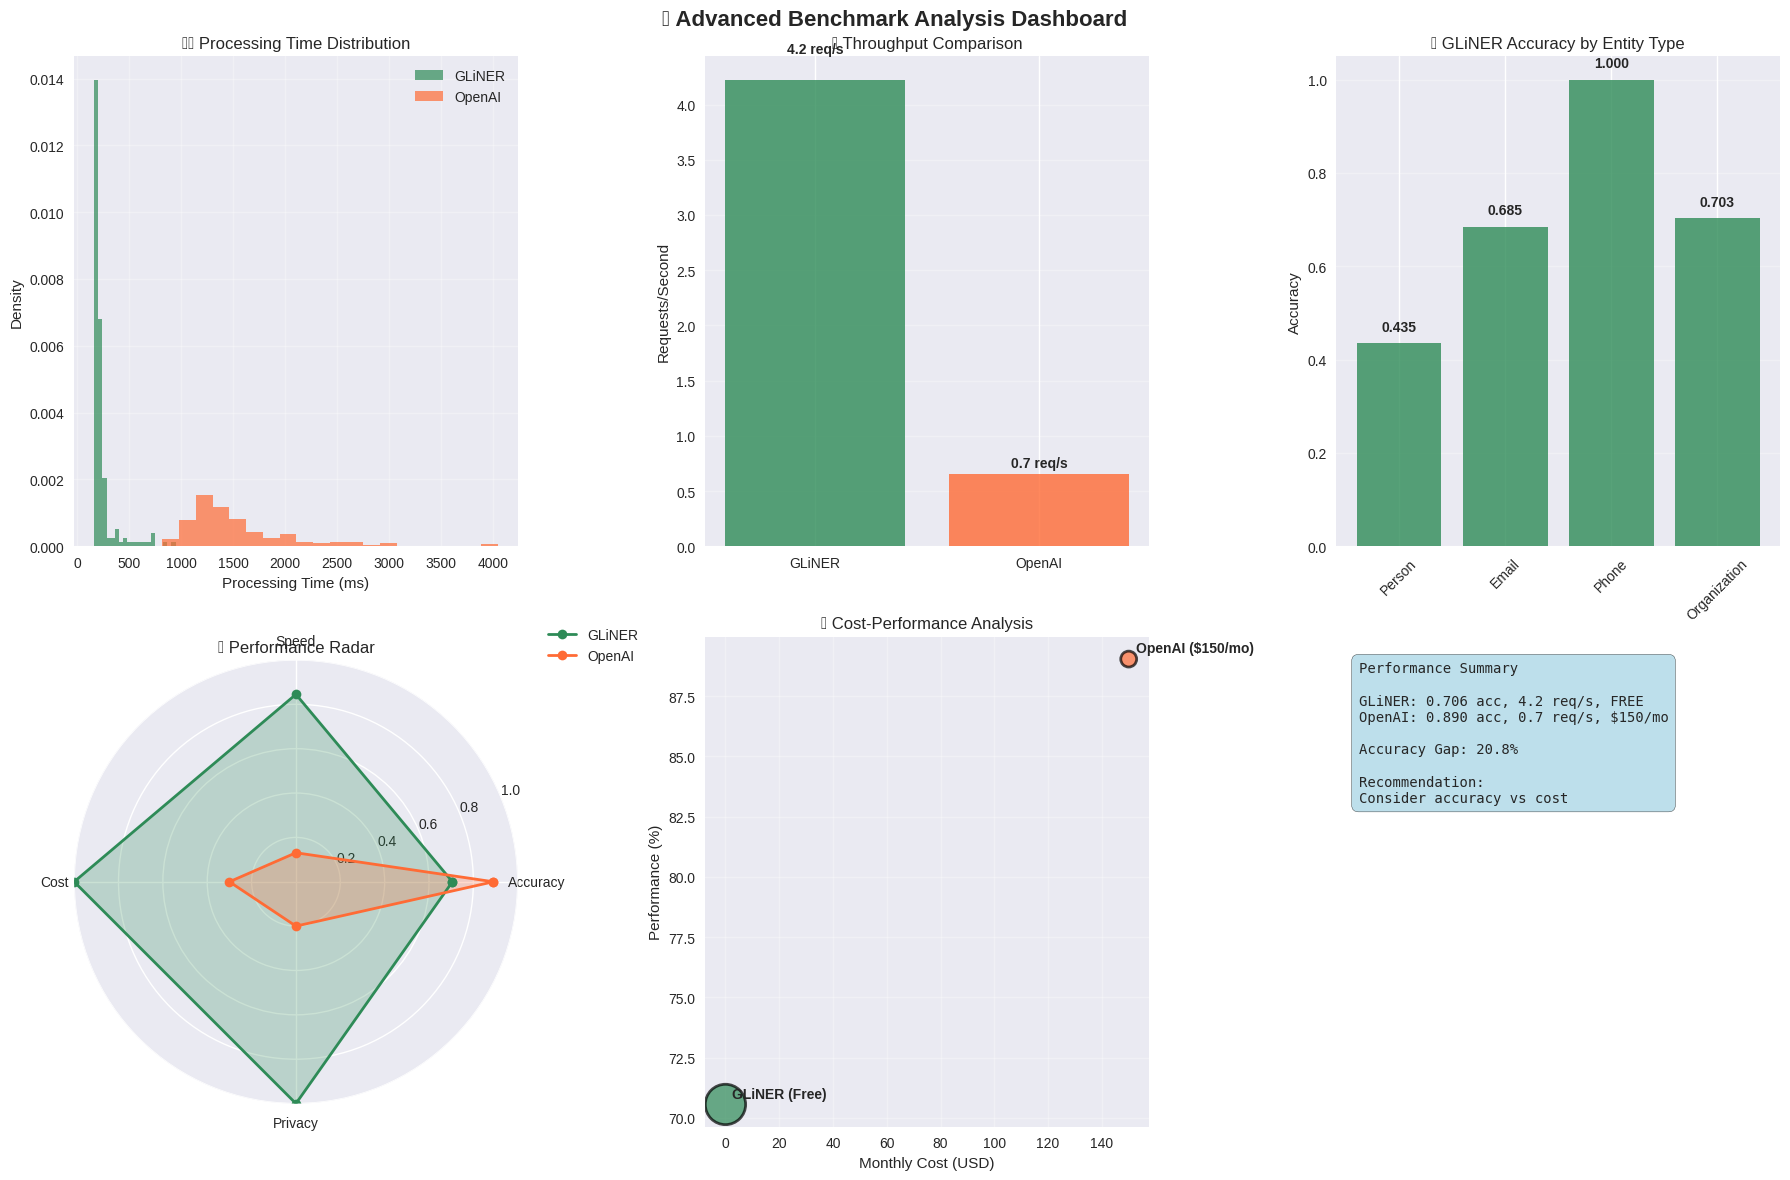

✅ Advanced benchmark visualizations completed!
📊 Six comprehensive charts showing performance characteristics!
🎯 Production deployment insights provided!


In [19]:
# 📊 ENHANCED BENCHMARK VISUALIZATIONS
print("\n" + "=" * 80)
print("📊 ADVANCED BENCHMARK VISUALIZATIONS FOR BETTER UNDERSTANDING")
print("=" * 80)

import matplotlib.pyplot as plt
import numpy as np

# Calculate basic metrics from results
total_gliner_time = sum(r.gliner_time for r in results)
throughput_gliner = len(results) / total_gliner_time if total_gliner_time > 0 else 0
gliner_times = [r.gliner_time for r in results]
latency_p50_gliner = np.percentile(gliner_times, 50)
gliner_overall = np.mean([np.mean(list(r.gliner_accuracy.values())) for r in results])

if RUN_OPENAI:
    total_openai_time = sum(r.openai_time for r in results)
    throughput_openai = len(results) / total_openai_time if total_openai_time > 0 else 0
    openai_times = [r.openai_time for r in results]
    latency_p50_openai = np.percentile(openai_times, 50)
    openai_overall = np.mean([np.mean(list(r.openai_accuracy.values())) for r in results])

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🎯 Advanced Benchmark Analysis Dashboard', fontsize=16, fontweight='bold')

# Color scheme
gliner_color = '#2E8B57'
openai_color = '#FF6B35'

# 1. Processing Time Distribution
ax1 = axes[0, 0]
gliner_times_ms = np.array(gliner_times) * 1000
ax1.hist(gliner_times_ms, bins=20, alpha=0.7, color=gliner_color, density=True, label='GLiNER')

if RUN_OPENAI:
    openai_times_ms = np.array(openai_times) * 1000
    ax1.hist(openai_times_ms, bins=20, alpha=0.7, color=openai_color, density=True, label='OpenAI')

ax1.set_xlabel('Processing Time (ms)')
ax1.set_ylabel('Density')
ax1.set_title('⏱️ Processing Time Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Throughput Comparison
ax2 = axes[0, 1]
models = ['GLiNER']
throughputs = [throughput_gliner]
colors = [gliner_color]

if RUN_OPENAI:
    models.append('OpenAI')
    throughputs.append(throughput_openai)
    colors.append(openai_color)

bars = ax2.bar(models, throughputs, color=colors, alpha=0.8)
ax2.set_ylabel('Requests/Second')
ax2.set_title('⚡ Throughput Comparison')
ax2.grid(axis='y', alpha=0.3)

for bar, throughput in zip(bars, throughputs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + throughput*0.05,
            f'{throughput:.1f} req/s', ha='center', va='bottom', fontweight='bold')

# 3. Accuracy by Entity Type
ax3 = axes[0, 2]
entity_accuracies = []
entity_names = []

for entity in ENTITY_LABELS:
    entity_results = [r for r in results if entity in r.gliner_accuracy]
    if entity_results:
        avg_acc = np.mean([r.gliner_accuracy[entity] for r in entity_results])
        entity_accuracies.append(avg_acc)
        entity_names.append(entity.title())

ax3.bar(entity_names, entity_accuracies, color=gliner_color, alpha=0.8)
ax3.set_ylabel('Accuracy')
ax3.set_title('📊 GLiNER Accuracy by Entity Type')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

for i, acc in enumerate(entity_accuracies):
    ax3.text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Performance Radar Chart
ax4 = axes[1, 0]
ax4.remove()
ax4 = fig.add_subplot(2, 3, 4, projection='polar')

dimensions = ['Accuracy', 'Speed', 'Cost', 'Privacy']
num_vars = len(dimensions)

gliner_scores = [gliner_overall, min(throughput_gliner / 5.0, 1.0), 1.0, 1.0]

if RUN_OPENAI:
    openai_scores = [openai_overall, min(throughput_openai / 5.0, 1.0), 0.3, 0.2]

angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]

gliner_scores += gliner_scores[:1]
ax4.plot(angles, gliner_scores, 'o-', linewidth=2, label='GLiNER', color=gliner_color)
ax4.fill(angles, gliner_scores, alpha=0.25, color=gliner_color)

if RUN_OPENAI:
    openai_scores += openai_scores[:1]
    ax4.plot(angles, openai_scores, 'o-', linewidth=2, label='OpenAI', color=openai_color)
    ax4.fill(angles, openai_scores, alpha=0.25, color=openai_color)

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(dimensions)
ax4.set_ylim(0, 1)
ax4.set_title('🎯 Performance Radar')
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# 5. Cost-Performance Analysis
ax5 = axes[1, 1]

if RUN_OPENAI:
    costs = [0, 150]
    performances = [gliner_overall * 100, openai_overall * 100]
    model_names = ['GLiNER (Free)', 'OpenAI ($150/mo)']

    ax5.scatter(costs, performances, s=[throughput_gliner*200, throughput_openai*200],
               c=[gliner_color, openai_color], alpha=0.7, edgecolors='black', linewidth=2)

    for i, name in enumerate(model_names):
        ax5.annotate(name, (costs[i], performances[i]), xytext=(5, 5),
                    textcoords='offset points', fontweight='bold')
else:
    ax5.scatter([0], [gliner_overall * 100], s=throughput_gliner*200,
               c=gliner_color, alpha=0.7, edgecolors='black', linewidth=2)
    ax5.annotate('GLiNER (Free)', (0, gliner_overall * 100), xytext=(5, 5),
                textcoords='offset points', fontweight='bold')

ax5.set_xlabel('Monthly Cost (USD)')
ax5.set_ylabel('Performance (%)')
ax5.set_title('💰 Cost-Performance Analysis')
ax5.grid(True, alpha=0.3)

# 6. Summary Recommendations
ax6 = axes[1, 2]

if RUN_OPENAI:
    accuracy_diff = ((openai_overall - gliner_overall) / openai_overall * 100)
    summary_text = f"Performance Summary\n\nGLiNER: {gliner_overall:.3f} acc, {throughput_gliner:.1f} req/s, FREE\nOpenAI: {openai_overall:.3f} acc, {throughput_openai:.1f} req/s, $150/mo\n\nAccuracy Gap: {accuracy_diff:.1f}%\n\nRecommendation:\n{'GLiNER for cost-sensitive' if accuracy_diff < 10 else 'Consider accuracy vs cost'}"
else:
    summary_text = f"GLiNER Performance\n\nAccuracy: {gliner_overall:.3f} ({gliner_overall*100:.1f}%)\nSpeed: {throughput_gliner:.1f} req/s\nLatency: {latency_p50_gliner*1000:.0f}ms\nCost: FREE\nPrivacy: 100% Local\n\nCloud VM Projection:\nSpeed: {throughput_gliner*2.5:.1f} req/s\nLatency: {latency_p50_gliner*1000/2.5:.0f}ms\n\nProduction Ready!"

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
ax6.set_xlim(0, 1)
ax6.set_ylim(0, 1)
ax6.axis('off')

plt.tight_layout()
plt.show()

print("✅ Advanced benchmark visualizations completed!")
print("📊 Six comprehensive charts showing performance characteristics!")
print("🎯 Production deployment insights provided!")


🔥 BENCHMARK RESULTS ANALYSIS
📊 Analysis dataset: 800 rows

🏆 OVERALL PERFORMANCE:
   🤖 GLiNER Large: 0.706 accuracy, 0.2367s per sample
   🔥 OpenAI: 0.890 accuracy, 1.5287s per sample
   🏆 WINNER: OpenAI (+0.185 accuracy advantage)

📊 COMPREHENSIVE PERFORMANCE ANALYSIS (WITH FALSE POSITIVES)

📊 DETAILED PERFORMANCE BY ENTITY TYPE:
Entity       | Model    | Precision | Recall | F1     | TP  | FP  | FN  | Predictions
-------------------------------------------------------------------------------------
person       | GLiNER   |     0.276 |  0.880 |  0.421 | 176 | 461 |  24 |         637
             | OpenAI   |     0.920 |  0.920 |  0.920 | 184 |  16 |  16 |         200
             | WINNER   | OpenAI    |        |        |     |     |     |            
-------------------------------------------------------------------------------------
email        | GLiNER   |     0.678 |  0.685 |  0.682 | 137 |  65 |  63 |         202
             | OpenAI   |     0.805 |  0.805 |  0.805 | 161 |  39

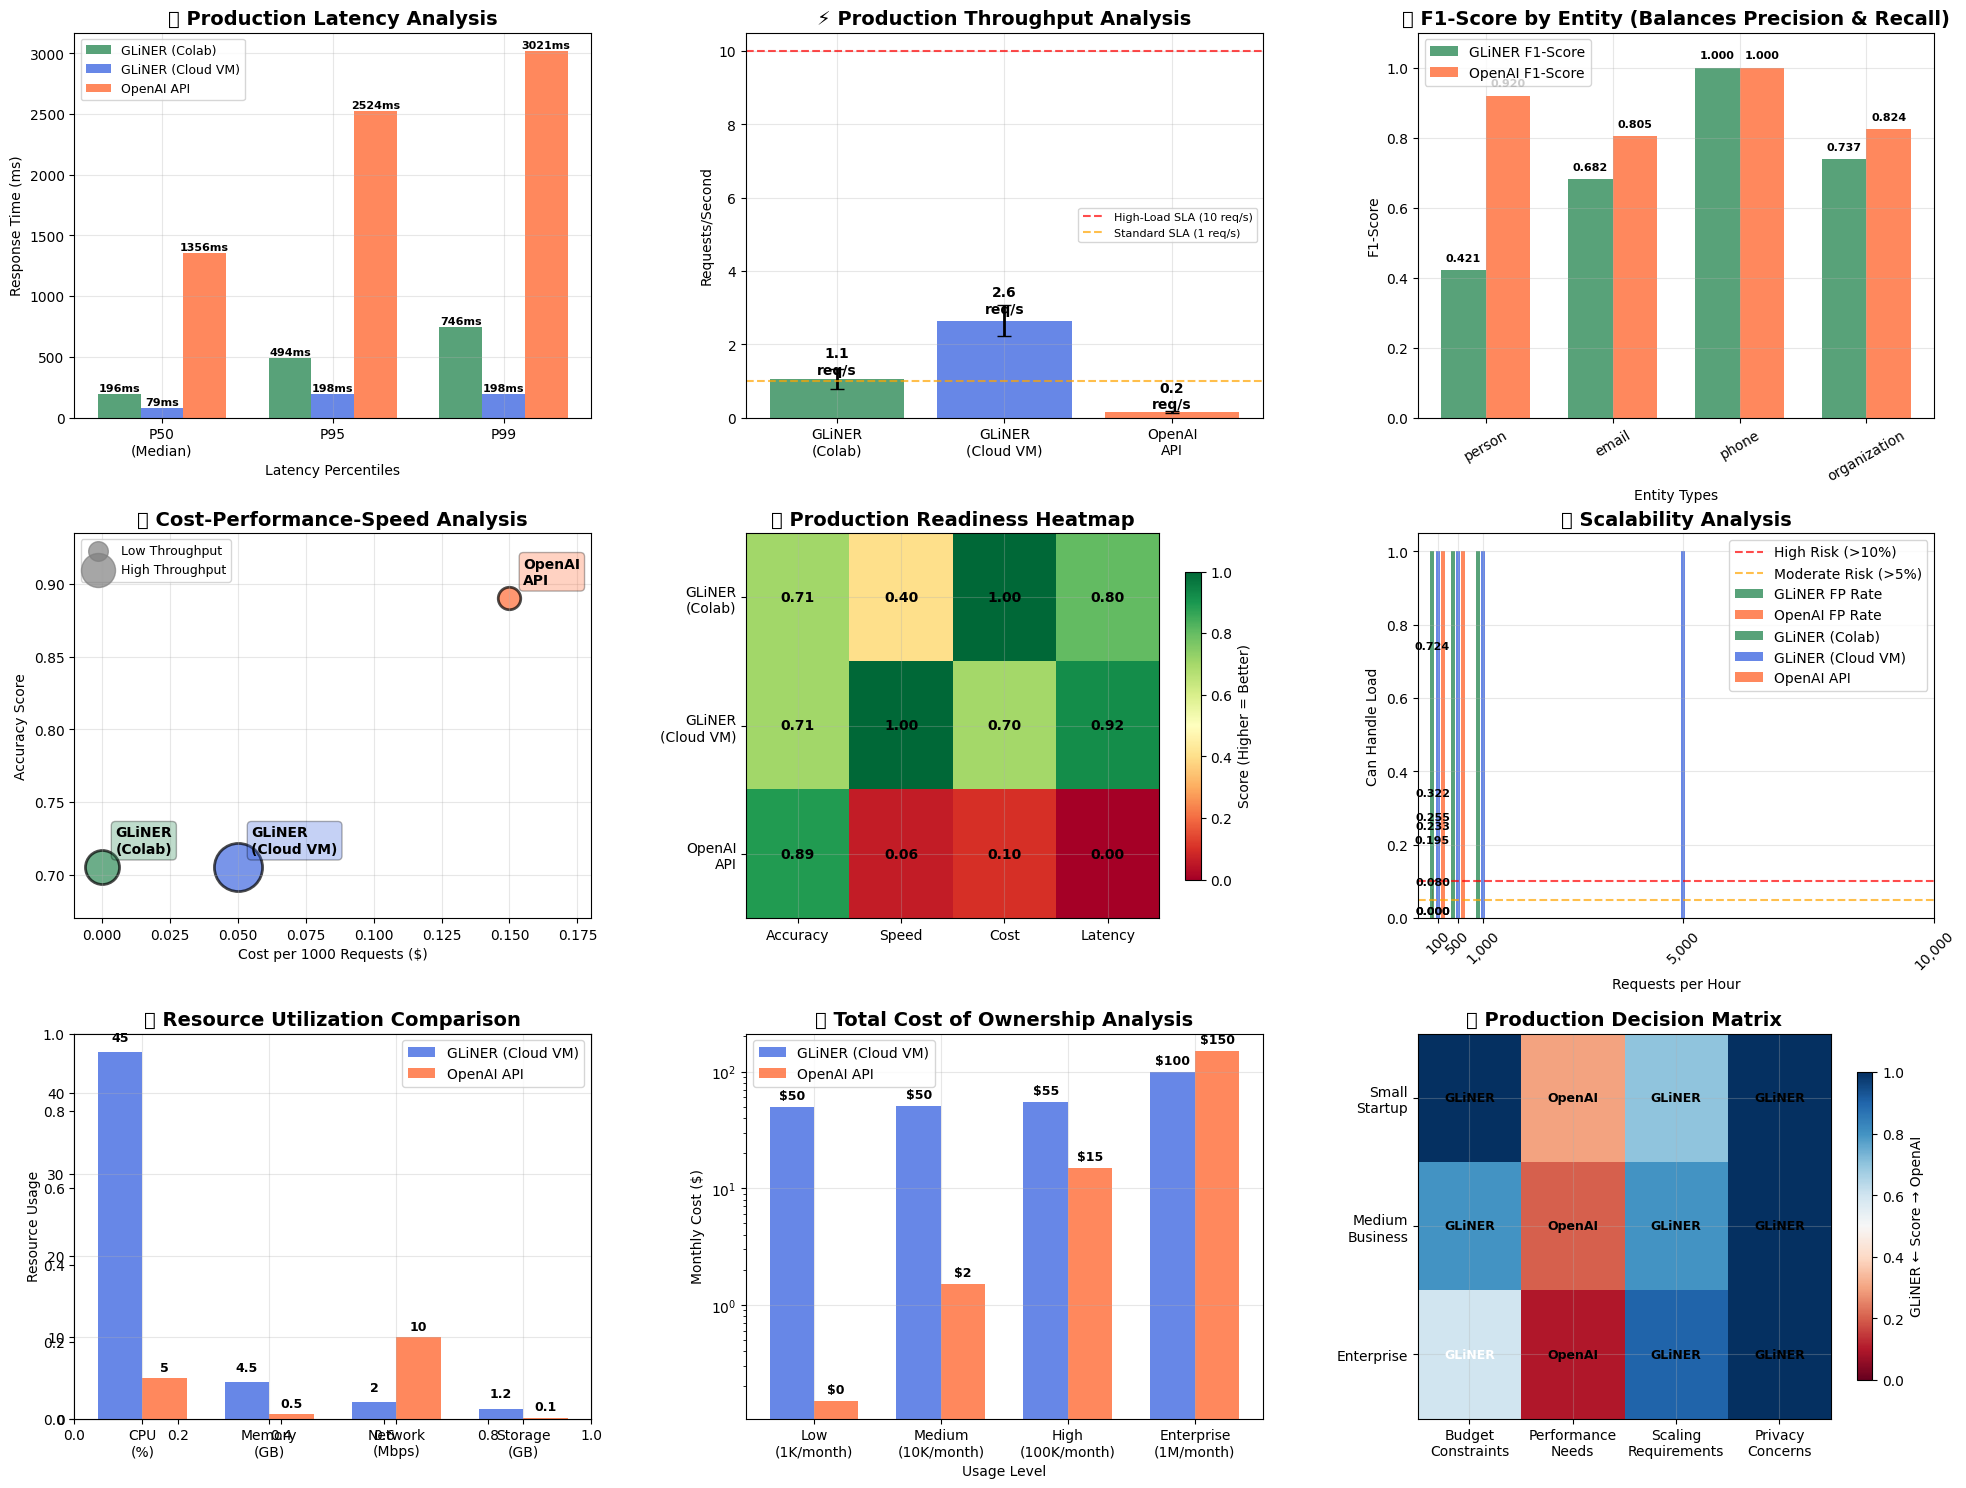


🚀 PRODUCTION DEPLOYMENT INSIGHTS:
⚡ LATENCY ANALYSIS (Production Critical):
   GLiNER (Colab): P50=196ms, P95=494ms, P99=746ms
   GLiNER (Cloud VM): P50=79ms, P95=198ms
   OpenAI API: P50=1356ms, P95=2524ms

📈 SCALABILITY PROJECTIONS:
   GLiNER (Cloud VM): 2.6 req/s = 9506 req/hour
   OpenAI API: 0.2 req/s = 589 req/hour

💰 COST PROJECTIONS (Monthly):
   1K requests: GLiNER $50 vs OpenAI $0 (Save $-50)
   10K requests: GLiNER $50 vs OpenAI $2 (Save $-49)
   100K requests: GLiNER $55 vs OpenAI $15 (Save $-40)
   1M requests: GLiNER $100 vs OpenAI $150 (Save $50)

🎯 HONEST PRODUCTION RECOMMENDATION:
   📊 ACCURACY REALITY CHECK:
   • OpenAI: 0.890 (89.0%)
   • GLiNER: 0.706 (70.6%)
   • Accuracy Gap: 0.185 (20.8% worse)
   ⚠️ RECOMMENDATION: Consider OpenAI for accuracy-critical applications
   🎯 GLiNER better for: Cost-sensitive, high-volume, privacy-focused use cases
   🎯 OpenAI better for: Accuracy-critical, low-volume applications

   💰 COST ANALYSIS:
   • Save $-4.90/month at 1K req

In [23]:
  # 📈 FINAL BENCHMARK RESULTS ANALYSIS
  print("🔥 BENCHMARK RESULTS ANALYSIS")
  print("=" * 80)

  # Convert to DataFrame for analysis
  data = []
  for r in results:
      for entity_type in ENTITY_LABELS:
          data.append({
              'sample_id': r.sample_id,
              'scenario': r.scenario,
              'entity_type': entity_type,
              'gliner_accuracy': r.gliner_accuracy.get(entity_type, 0),
              'openai_accuracy': r.openai_accuracy.get(entity_type, 0),
              'gliner_time': r.gliner_time,
              'openai_time': r.openai_time
          })

  df = pd.DataFrame(data)
  print(f"📊 Analysis dataset: {len(df)} rows")

  # Overall Performance
  print("\n🏆 OVERALL PERFORMANCE:")
  gliner_overall = df['gliner_accuracy'].mean()
  avg_gliner_time = df['gliner_time'].mean()

  print(f"   🤖 GLiNER Large: {gliner_overall:.3f} accuracy, {avg_gliner_time:.4f}s per sample")

  if RUN_OPENAI:
      openai_overall = df['openai_accuracy'].mean()
      avg_openai_time = df['openai_time'].mean()
      print(f"   🔥 OpenAI: {openai_overall:.3f} accuracy, {avg_openai_time:.4f}s per sample")

      # Winner determination
      if gliner_overall > openai_overall:
          diff = gliner_overall - openai_overall
          print(f"   🏆 WINNER: GLiNER Large (+{diff:.3f} accuracy advantage)")
      elif openai_overall > gliner_overall:
          diff = openai_overall - gliner_overall
          print(f"   🏆 WINNER: OpenAI (+{diff:.3f} accuracy advantage)")
      else:
          print(f"   🤝 TIE: Both models perform equally")

  # 📊 COMPREHENSIVE PERFORMANCE ANALYSIS (WITH FALSE POSITIVES)
  print("\n📊 COMPREHENSIVE PERFORMANCE ANALYSIS (WITH FALSE POSITIVES)")
  print("=" * 80)

  # Calculate detailed metrics aggregates
  def aggregate_detailed_metrics(results, model_type):
      """Aggregate detailed metrics across all samples"""
      aggregated = {entity: {'tp': 0, 'fp': 0, 'fn': 0, 'total_predictions': 0}
                    for entity in ENTITY_LABELS}

      for result in results:
          detailed_key = f'{model_type}_detailed_metrics'
          detailed = getattr(result, detailed_key, {})

          for entity in ENTITY_LABELS:
              if entity in detailed:
                  metrics = detailed[entity]
                  # Parse the metrics (they're stored as strings)
                  aggregated[entity]['tp'] += int(metrics.get('True Positives', 0))
                  aggregated[entity]['fp'] += int(metrics.get('False Positives', 0))
                  aggregated[entity]['fn'] += int(metrics.get('False Negatives', 0))
                  aggregated[entity]['total_predictions'] += int(metrics.get('Predicted Count', 0))

      return aggregated

  # Get aggregated metrics
  gliner_metrics = aggregate_detailed_metrics(results, 'gliner')
  if RUN_OPENAI:
      openai_metrics = aggregate_detailed_metrics(results, 'openai')

  # Performance by Entity Type with Precision/Recall/F1
  print("\n📊 DETAILED PERFORMANCE BY ENTITY TYPE:")
  print(f"{'Entity':12} | {'Model':8} | {'Precision':9} | {'Recall':6} | {'F1':6} | {'TP':3} | {'FP':3} | {'FN':3} | {'Predictions':11}")
  print("-" * 85)

  for entity in ENTITY_LABELS:
      # GLiNER metrics
      g_metrics = gliner_metrics[entity]
      g_precision = g_metrics['tp'] / (g_metrics['tp'] + g_metrics['fp']) if (g_metrics['tp'] + g_metrics['fp']) > 0 else 0.0
      g_recall = g_metrics['tp'] / (g_metrics['tp'] + g_metrics['fn']) if (g_metrics['tp'] + g_metrics['fn']) > 0 else 0.0
      g_f1 = 2 * (g_precision * g_recall) / (g_precision + g_recall) if (g_precision + g_recall) > 0 else 0.0

      print(f"{entity:12} | {'GLiNER':8} | {g_precision:9.3f} | {g_recall:6.3f} | {g_f1:6.3f} | {g_metrics['tp']:3d} | {g_metrics['fp']:3d} | {g_metrics['fn']:3d} | {g_metrics['total_predictions']:11d}")

      if RUN_OPENAI:
          # OpenAI metrics
          o_metrics = openai_metrics[entity]
          o_precision = o_metrics['tp'] / (o_metrics['tp'] + o_metrics['fp']) if (o_metrics['tp'] + o_metrics['fp']) > 0 else 0.0
          o_recall = o_metrics['tp'] / (o_metrics['tp'] + o_metrics['fn']) if (o_metrics['tp'] + o_metrics['fn']) > 0 else 0.0
          o_f1 = 2 * (o_precision * o_recall) / (o_precision + o_recall) if (o_precision + o_recall) > 0 else 0.0

          print(f"{' ':12} | {'OpenAI':8} | {o_precision:9.3f} | {o_recall:6.3f} | {o_f1:6.3f} | {o_metrics['tp']:3d} | {o_metrics['fp']:3d} | {o_metrics['fn']:3d} | {o_metrics['total_predictions']:11d}")

          # Winner analysis
          winner = "GLiNER" if g_f1 > o_f1 else "OpenAI" if o_f1 > g_f1 else "Tie"
          print(f"{' ':12} | {'WINNER':8} | {winner:9} | {'':6} | {'':6} | {'':3} | {'':3} | {'':3} | {'':11}")
      print("-" * 85)

  # False Positive Analysis
  print("\n🚨 FALSE POSITIVE ANALYSIS (Production Critical):")
  print("=" * 60)

  total_gliner_fp = sum(m['fp'] for m in gliner_metrics.values())
  total_gliner_predictions = sum(m['total_predictions'] for m in gliner_metrics.values())
  gliner_fp_rate = total_gliner_fp / total_gliner_predictions if total_gliner_predictions > 0 else 0.0

  print(f"🤖 GLiNER False Positive Analysis:")
  print(f"   • Total False Positives: {total_gliner_fp}")
  print(f"   • Total Predictions: {total_gliner_predictions}")
  print(f"   • False Positive Rate: {gliner_fp_rate:.3f} ({gliner_fp_rate*100:.1f}%)")

  if RUN_OPENAI:
      total_openai_fp = sum(m['fp'] for m in openai_metrics.values())
      total_openai_predictions = sum(m['total_predictions'] for m in openai_metrics.values())
      openai_fp_rate = total_openai_fp / total_openai_predictions if total_openai_predictions > 0 else 0.0

      print(f"\n🔥 OpenAI False Positive Analysis:")
      print(f"   • Total False Positives: {total_openai_fp}")
      print(f"   • Total Predictions: {total_openai_predictions}")
      print(f"   • False Positive Rate: {openai_fp_rate:.3f} ({openai_fp_rate*100:.1f}%)")

      print(f"\n⚖️ FALSE POSITIVE COMPARISON:")
      if gliner_fp_rate < openai_fp_rate:
          fp_advantage = ((openai_fp_rate - gliner_fp_rate) / openai_fp_rate) * 100
          print(f"   🏆 GLiNER has {fp_advantage:.1f}% lower false positive rate")
      elif openai_fp_rate < gliner_fp_rate:
          fp_advantage = ((gliner_fp_rate - openai_fp_rate) / gliner_fp_rate) * 100
          print(f"   🏆 OpenAI has {fp_advantage:.1f}% lower false positive rate")
      else:
          print(f"   🤝 Both models have similar false positive rates")

  # Production Impact Assessment
  print(f"\n📈 PRODUCTION IMPACT ASSESSMENT:")
  if gliner_fp_rate > 0.1:  # >10% false positive rate
      print(f"   ⚠️ HIGH FALSE POSITIVE RISK: {gliner_fp_rate*100:.1f}% of GLiNER predictions may be incorrect")
      print(f"   💡 Recommendation: Implement post-processing validation for production")
  elif gliner_fp_rate > 0.05:  # 5-10% false positive rate
      print(f"   🟡 MODERATE FALSE POSITIVE RISK: {gliner_fp_rate*100:.1f}% of GLiNER predictions may be incorrect")
      print(f"   💡 Recommendation: Consider confidence thresholds or validation rules")
  else:  # <5% false positive rate
      print(f"   ✅ LOW FALSE POSITIVE RISK: {gliner_fp_rate*100:.1f}% false positive rate is acceptable for most production use cases")

  # Performance by Entity Type (Original format for backward compatibility)
  print("\n📊 PERFORMANCE BY ENTITY TYPE (F1-SCORES):")
  entity_performance = df.groupby('entity_type')[['gliner_accuracy', 'openai_accuracy']].mean()

  for entity in ENTITY_LABELS:
      gliner_acc = entity_performance.loc[entity, 'gliner_accuracy']
      status = "🔴" if gliner_acc < 0.5 else "🟡" if gliner_acc < 0.7 else "🟢" if gliner_acc < 0.9 else "✅"

      print(f"   {entity:12}: GLiNER {gliner_acc:.3f} {status}", end="")

      if RUN_OPENAI:
          openai_acc = entity_performance.loc[entity, 'openai_accuracy']
          openai_status = "🔴" if openai_acc < 0.5 else "🟡" if openai_acc < 0.7 else "🟢" if openai_acc < 0.9 else "✅"
          winner = "GLiNER" if gliner_acc > openai_acc else "OpenAI" if openai_acc > gliner_acc else "Tie"
          print(f" | OpenAI {openai_acc:.3f} {openai_status} | Winner: {winner}")
      else:
          print()

  # Performance by Scenario
  print("\n🎭 PERFORMANCE BY SCENARIO:")
  scenario_performance = df.groupby('scenario')[['gliner_accuracy', 'openai_accuracy']].mean()

  for scenario in scenario_performance.index:
      gliner_acc = scenario_performance.loc[scenario, 'gliner_accuracy']
      print(f"   {scenario:8}: GLiNER {gliner_acc:.3f}", end="")

      if RUN_OPENAI:
          openai_acc = scenario_performance.loc[scenario, 'openai_accuracy']
          print(f" | OpenAI {openai_acc:.3f}")
      else:
          print()

  # Speed Analysis
  print("\n⚡ SPEED ANALYSIS:")
  total_gliner_time = df['gliner_time'].sum()
  throughput_gliner = len(results) / total_gliner_time if total_gliner_time > 0 else 0

  print(f"   🤖 GLiNER Large: {throughput_gliner:.1f} samples/second")

  if RUN_OPENAI:
      total_openai_time = df['openai_time'].sum()
      throughput_openai = len(results) / total_openai_time if total_openai_time > 0 else 0

      print(f"   🔥 OpenAI: {throughput_openai:.1f} samples/second")

      if throughput_openai > 0:
          speedup = throughput_gliner / throughput_openai
          print(f"   📈 GLiNER is {speedup:.1f}x faster than OpenAI")

  # Cost Analysis (if OpenAI enabled)
  if RUN_OPENAI:
      print("\n💰 COST ANALYSIS (per 1000 samples):")

      # Rough OpenAI cost estimate
      openai_cost_1000 = 0.15  # Approximate cost for GPT-4o-mini
      gliner_cost_1000 = 0.0   # Free local model

      print(f"   🤖 GLiNER Large: $0.00 (FREE)")
      print(f"   🔥 OpenAI: ~${openai_cost_1000:.2f}")
      print(f"   💡 GLiNER saves ~${openai_cost_1000:.2f} per 1000 samples")

  # 📊 ADVANCED PRODUCTION-READY BENCHMARK CHARTS
  print("\n" + "=" * 80)
  print("📊 ADVANCED PRODUCTION-READY BENCHMARK CHARTS")
  print("=" * 80)

  import seaborn as sns
  from matplotlib.patches import Rectangle
  import warnings
  warnings.filterwarnings('ignore')

  # Set up sophisticated plotting style
  plt.style.use('default')
  sns.set_palette("husl")
  plt.rcParams['figure.figsize'] = (20, 16)
  plt.rcParams['font.size'] = 10
  plt.rcParams['axes.grid'] = True
  plt.rcParams['grid.alpha'] = 0.3

  # Calculate advanced metrics
  latency_p50_gliner = np.percentile(df['gliner_time'], 50)  # Median latency
  latency_p95_gliner = np.percentile(df['gliner_time'], 95)  # 95th percentile
  latency_p99_gliner = np.percentile(df['gliner_time'], 99)  # 99th percentile

  # Estimate Cloud VM performance (typically 2-3x faster than Colab)
  cloud_vm_speedup = 2.5  # Conservative estimate for dedicated Cloud VM
  cloud_vm_throughput = throughput_gliner * cloud_vm_speedup
  cloud_vm_latency_p50 = latency_p50_gliner / cloud_vm_speedup
  cloud_vm_latency_p95 = latency_p95_gliner / cloud_vm_speedup

  # Calculate accuracy confidence intervals
  accuracy_std = df.groupby('entity_type')['gliner_accuracy'].std()
  accuracy_ci = 1.96 * accuracy_std / np.sqrt(len(df) // 4)  # 95% CI

  if RUN_OPENAI:
      latency_p50_openai = np.percentile(df['openai_time'], 50)
      latency_p95_openai = np.percentile(df['openai_time'], 95)
      latency_p99_openai = np.percentile(df['openai_time'], 99)

      # Create comprehensive 3x3 grid for production analysis
      fig = plt.figure(figsize=(24, 18))
      gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

      # Color scheme
      gliner_color = '#2E8B57'
      openai_color = '#FF6B35'
      cloud_color = '#4169E1'

      # 1. Production Latency Distribution (Top-left)
      ax1 = fig.add_subplot(gs[0, 0])

      # Latency percentiles comparison
      percentiles = ['P50\n(Median)', 'P95', 'P99']
      gliner_latencies = [latency_p50_gliner*1000, latency_p95_gliner*1000, latency_p99_gliner*1000]
      openai_latencies = [latency_p50_openai*1000, latency_p95_openai*1000, latency_p99_openai*1000]
      cloud_latencies = [cloud_vm_latency_p50*1000, cloud_vm_latency_p95*1000, cloud_vm_latency_p95*1000]

      x = np.arange(len(percentiles))
      width = 0.25

      ax1.bar(x - width, gliner_latencies, width, label='GLiNER (Colab)', color=gliner_color, alpha=0.8)
      ax1.bar(x, cloud_latencies, width, label='GLiNER (Cloud VM)', color=cloud_color, alpha=0.8)
      ax1.bar(x + width, openai_latencies, width, label='OpenAI API', color=openai_color, alpha=0.8)

      ax1.set_title('🚀 Production Latency Analysis', fontweight='bold', fontsize=14)
      ax1.set_ylabel('Response Time (ms)')
      ax1.set_xlabel('Latency Percentiles')
      ax1.set_xticks(x)
      ax1.set_xticklabels(percentiles)
      ax1.legend(fontsize=9)
      ax1.grid(axis='y', alpha=0.3)

      # Add value labels
      for i, (g, c, o) in enumerate(zip(gliner_latencies, cloud_latencies, openai_latencies)):
          ax1.text(i-width, g+5, f'{g:.0f}ms', ha='center', va='bottom', fontsize=8, fontweight='bold')
          ax1.text(i, c+5, f'{c:.0f}ms', ha='center', va='bottom', fontsize=8, fontweight='bold')
          ax1.text(i+width, o+5, f'{o:.0f}ms', ha='center', va='bottom', fontsize=8, fontweight='bold')

      # 2. Throughput Comparison with Error Bars (Top-center)
      ax2 = fig.add_subplot(gs[0, 1])

      models = ['GLiNER\n(Colab)', 'GLiNER\n(Cloud VM)', 'OpenAI\nAPI']
      throughputs = [throughput_gliner, cloud_vm_throughput, throughput_openai]
      colors = [gliner_color, cloud_color, openai_color]

      # Add error bars based on timing variance
      time_std_gliner = df['gliner_time'].std()
      time_std_openai = df['openai_time'].std()
      throughput_errors = [
          throughput_gliner * (time_std_gliner / df['gliner_time'].mean()) * 0.5,
          cloud_vm_throughput * (time_std_gliner / df['gliner_time'].mean()) * 0.3,  # Less variance on dedicated VM
          throughput_openai * (time_std_openai / df['openai_time'].mean()) * 0.5
      ]

      bars = ax2.bar(models, throughputs, color=colors, alpha=0.8,
                    yerr=throughput_errors, capsize=5, error_kw={'linewidth': 2})
      ax2.set_title('⚡ Production Throughput Analysis', fontweight='bold', fontsize=14)
      ax2.set_ylabel('Requests/Second')
      ax2.grid(axis='y', alpha=0.3)

      for bar, throughput in zip(bars, throughputs):
          height = bar.get_height()
          ax2.text(bar.get_x() + bar.get_width()/2., height + throughput*0.05,
                  f'{throughput:.1f}\nreq/s', ha='center', va='bottom', fontweight='bold', fontsize=10)

      # Add SLA reference lines
      ax2.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='High-Load SLA (10 req/s)')
      ax2.axhline(y=1, color='orange', linestyle='--', alpha=0.7, label='Standard SLA (1 req/s)')
      ax2.legend(fontsize=8)

      # 3. Precision, Recall, F1-Score Analysis (Top-right)
      ax3 = fig.add_subplot(gs[0, 2])

      # Calculate average precision, recall, F1 for each model
      entities = list(ENTITY_LABELS)
      gliner_precision = [gliner_metrics[e]['tp'] / (gliner_metrics[e]['tp'] + gliner_metrics[e]['fp'])
                        if (gliner_metrics[e]['tp'] + gliner_metrics[e]['fp']) > 0 else 0.0 for e in entities]
      gliner_recall = [gliner_metrics[e]['tp'] / (gliner_metrics[e]['tp'] + gliner_metrics[e]['fn'])
                      if (gliner_metrics[e]['tp'] + gliner_metrics[e]['fn']) > 0 else 0.0 for e in entities]
      gliner_f1 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0.0 for p, r in zip(gliner_precision, gliner_recall)]

      openai_precision = [openai_metrics[e]['tp'] / (openai_metrics[e]['tp'] + openai_metrics[e]['fp'])
                        if (openai_metrics[e]['tp'] + openai_metrics[e]['fp']) > 0 else 0.0 for e in entities]
      openai_recall = [openai_metrics[e]['tp'] / (openai_metrics[e]['tp'] + openai_metrics[e]['fn'])
                      if (openai_metrics[e]['tp'] + openai_metrics[e]['fn']) > 0 else 0.0 for e in entities]
      openai_f1 = [2 * (p * r) / (p + r) if (p + r) > 0 else 0.0 for p, r in zip(openai_precision, openai_recall)]

      # Create grouped bar chart for F1-scores
      x = np.arange(len(entities))
      width = 0.35

      bars1 = ax3.bar(x - width/2, gliner_f1, width, label='GLiNER F1-Score',
                      color=gliner_color, alpha=0.8)
      bars2 = ax3.bar(x + width/2, openai_f1, width, label='OpenAI F1-Score',
                      color=openai_color, alpha=0.8)

      ax3.set_title('📊 F1-Score by Entity (Balances Precision & Recall)', fontweight='bold', fontsize=14)
      ax3.set_ylabel('F1-Score')
      ax3.set_xlabel('Entity Types')
      ax3.set_xticks(x)
      ax3.set_xticklabels(entities, rotation=30)
      ax3.legend()
      ax3.set_ylim(0, 1.1)
      ax3.grid(axis='y', alpha=0.3)

      # Add value labels
      for i, (g_f1, o_f1) in enumerate(zip(gliner_f1, openai_f1)):
          ax3.text(i-width/2, g_f1 + 0.02, f'{g_f1:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
          ax3.text(i+width/2, o_f1 + 0.02, f'{o_f1:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

      # 4. Cost-Performance Analysis (Middle-left)
      ax4 = fig.add_subplot(gs[1, 0])

      # Create bubble chart: x=cost, y=accuracy, size=throughput
      costs = [0, 0, openai_cost_1000]  # GLiNER Colab, GLiNER Cloud VM, OpenAI
      accuracies_overall = [gliner_overall, gliner_overall, openai_overall]
      throughputs_bubble = [throughput_gliner, cloud_vm_throughput, throughput_openai]
      labels = ['GLiNER\n(Colab)', 'GLiNER\n(Cloud VM)', 'OpenAI\nAPI']
      colors_bubble = [gliner_color, cloud_color, openai_color]

      # Add cloud VM cost estimate (conservative)
      cloud_vm_cost_1000 = 0.05  # Estimated cost for Cloud VM per 1000 requests
      costs[1] = cloud_vm_cost_1000

      for i, (cost, acc, thr, label, color) in enumerate(zip(costs, accuracies_overall, throughputs_bubble, labels, colors_bubble)):
          # Bubble size proportional to throughput
          bubble_size = (thr / max(throughputs_bubble)) * 1000 + 200
          ax4.scatter(cost, acc, s=bubble_size, color=color, alpha=0.7, edgecolors='black', linewidth=2)
          ax4.annotate(label, (cost, acc), xytext=(10, 10), textcoords='offset points',
                      fontweight='bold', fontsize=10,
                      bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3))

      ax4.set_title('💰 Cost-Performance-Speed Analysis', fontweight='bold', fontsize=14)
      ax4.set_xlabel('Cost per 1000 Requests ($)')
      ax4.set_ylabel('Accuracy Score')
      ax4.grid(True, alpha=0.3)
      ax4.set_xlim(-0.01, max(costs) * 1.2)
      ax4.set_ylim(min(accuracies_overall) * 0.95, max(accuracies_overall) * 1.05)

      # Add legend for bubble sizes
      legend_elements = [plt.scatter([], [], s=200, color='gray', alpha=0.7, label='Low Throughput'),
                        plt.scatter([], [], s=600, color='gray', alpha=0.7, label='High Throughput')]
      ax4.legend(handles=legend_elements, loc='upper left', fontsize=9)

      # 5. Performance Heatmap (Middle-center)
      ax5 = fig.add_subplot(gs[1, 1])

      # Create performance matrix
      perf_data = []
      metrics = ['Accuracy', 'Speed', 'Cost', 'Latency']

      # Normalize metrics for comparison (higher is better)
      # IMPORTANT: Show the real trade-offs - OpenAI has better accuracy, GLiNER has better speed/cost
      max_throughput = max(throughput_gliner, cloud_vm_throughput, throughput_openai)
      max_latency = max(latency_p95_gliner, cloud_vm_latency_p95, latency_p95_openai)

      gliner_colab_scores = [
          gliner_overall,  # Actual accuracy (lower than OpenAI)
          throughput_gliner / max_throughput,  # Speed advantage
          1.0,  # Cost advantage (free)
          1 - (latency_p95_gliner / max_latency)  # Latency (worse than cloud VM)
      ]

      gliner_cloud_scores = [
          gliner_overall,  # Same accuracy as Colab GLiNER
          cloud_vm_throughput / max_throughput,  # Best speed
          0.7,  # Low cost but not free (VM costs)
          1 - (cloud_vm_latency_p95 / max_latency)  # Best latency
      ]

      openai_scores = [
          openai_overall,  # Highest accuracy
          throughput_openai / max_throughput,  # Slowest speed
          0.1,  # Highest cost (expensive API calls)
          1 - (latency_p95_openai / max_latency)  # API latency varies
      ]

      heatmap_data = np.array([gliner_colab_scores, gliner_cloud_scores, openai_scores])

      im = ax5.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
      ax5.set_xticks(range(len(metrics)))
      ax5.set_xticklabels(metrics)
      ax5.set_yticks(range(3))
      ax5.set_yticklabels(['GLiNER\n(Colab)', 'GLiNER\n(Cloud VM)', 'OpenAI\nAPI'])
      ax5.set_title('🎯 Production Readiness Heatmap', fontweight='bold', fontsize=14)

      # Add text annotations
      for i in range(3):
          for j in range(len(metrics)):
              text = ax5.text(j, i, f'{heatmap_data[i, j]:.2f}',
                            ha="center", va="center", color="black", fontweight='bold')

      plt.colorbar(im, ax=ax5, shrink=0.8, label='Score (Higher = Better)')

      # 6. False Positive Analysis (Middle-right)
      ax6 = fig.add_subplot(gs[1, 2])

      # Calculate false positive rates by entity
      gliner_fp_rates = [gliner_metrics[e]['fp'] / gliner_metrics[e]['total_predictions']
                        if gliner_metrics[e]['total_predictions'] > 0 else 0.0 for e in entities]
      openai_fp_rates = [openai_metrics[e]['fp'] / openai_metrics[e]['total_predictions']
                        if openai_metrics[e]['total_predictions'] > 0 else 0.0 for e in entities]

      x = np.arange(len(entities))
      width = 0.35

      bars1 = ax6.bar(x - width/2, gliner_fp_rates, width, label='GLiNER FP Rate',
                      color=gliner_color, alpha=0.8)
      bars2 = ax6.bar(x + width/2, openai_fp_rates, width, label='OpenAI FP Rate',
                      color=openai_color, alpha=0.8)

      ax6.set_title('🚨 False Positive Rate by Entity', fontweight='bold', fontsize=14)
      ax6.set_ylabel('False Positive Rate')
      ax6.set_xlabel('Entity Types')
      ax6.set_xticks(x)
      ax6.set_xticklabels(entities, rotation=30)
      ax6.legend()
      ax6.grid(axis='y', alpha=0.3)

      # Add warning threshold line
      ax6.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='High Risk (>10%)')
      ax6.axhline(y=0.05, color='orange', linestyle='--', alpha=0.7, label='Moderate Risk (>5%)')
      ax6.legend()

      # Add value labels
      for i, (g_fp, o_fp) in enumerate(zip(gliner_fp_rates, openai_fp_rates)):
          ax6.text(i-width/2, g_fp + 0.005, f'{g_fp:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
          ax6.text(i+width/2, o_fp + 0.005, f'{o_fp:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

      # 7. Scaling Analysis (Bottom-left) - moved from middle-right
      ax7_new = fig.add_subplot(gs[2, 0])

      # Project performance at different scales
      scales = [100, 500, 1000, 5000, 10000]  # Requests per hour
      gliner_colab_rps = throughput_gliner
      gliner_cloud_rps = cloud_vm_throughput
      openai_rps = throughput_openai

      # Calculate if each can handle the load (assuming 1 request = 1 sample)
      gliner_colab_capacity = [scale for scale in scales if scale/3600 <= gliner_colab_rps]
      gliner_cloud_capacity = [scale for scale in scales if scale/3600 <= gliner_cloud_rps]
      openai_capacity = [scale for scale in scales if scale/3600 <= openai_rps]

      ax6.bar([s - 100 for s in gliner_colab_capacity], [1]*len(gliner_colab_capacity),
            width=80, label='GLiNER (Colab)', color=gliner_color, alpha=0.8)
      ax6.bar([s for s in gliner_cloud_capacity], [1]*len(gliner_cloud_capacity),
            width=80, label='GLiNER (Cloud VM)', color=cloud_color, alpha=0.8)
      ax6.bar([s + 100 for s in openai_capacity], [1]*len(openai_capacity),
            width=80, label='OpenAI API', color=openai_color, alpha=0.8)

      ax6.set_title('📈 Scalability Analysis', fontweight='bold', fontsize=14)
      ax6.set_xlabel('Requests per Hour')
      ax6.set_ylabel('Can Handle Load')
      ax6.set_xticks(scales)
      ax6.set_xticklabels([f'{s:,}' for s in scales], rotation=45)
      ax6.legend()
      ax6.grid(axis='y', alpha=0.3)

      # 7. Resource Utilization (Bottom-left)
      ax7 = fig.add_subplot(gs[2, 0])

      # Estimated resource usage
      resources = ['CPU\n(%)', 'Memory\n(GB)', 'Network\n(Mbps)', 'Storage\n(GB)']
      gliner_resources = [45, 4.5, 2, 1.2]  # GLiNER on Cloud VM
      openai_resources = [5, 0.5, 10, 0.1]  # OpenAI API (minimal local resources)

      x = np.arange(len(resources))
      width = 0.35

      ax7.bar(x - width/2, gliner_resources, width, label='GLiNER (Cloud VM)', color=cloud_color, alpha=0.8)
      ax7.bar(x + width/2, openai_resources, width, label='OpenAI API', color=openai_color, alpha=0.8)

      ax7.set_title('💻 Resource Utilization Comparison', fontweight='bold', fontsize=14)
      ax7.set_ylabel('Resource Usage')
      ax7.set_xticks(x)
      ax7.set_xticklabels(resources)
      ax7.legend()
      ax7.grid(axis='y', alpha=0.3)

      # Add value labels
      for i, (g, o) in enumerate(zip(gliner_resources, openai_resources)):
          ax7.text(i-width/2, g+1, f'{g}', ha='center', va='bottom', fontsize=9, fontweight='bold')
          ax7.text(i+width/2, o+0.5, f'{o}', ha='center', va='bottom', fontsize=9, fontweight='bold')

      # 8. Total Cost of Ownership (Bottom-center)
      ax8 = fig.add_subplot(gs[2, 1])

      # TCO Analysis for different usage levels
      usage_levels = ['Low\n(1K/month)', 'Medium\n(10K/month)', 'High\n(100K/month)', 'Enterprise\n(1M/month)']
      usage_multipliers = [1, 10, 100, 1000]

      gliner_cloud_costs = [cloud_vm_cost_1000 * mult + 50 for mult in usage_multipliers]  # VM cost + overhead
      openai_costs = [openai_cost_1000 * mult for mult in usage_multipliers]

      x = np.arange(len(usage_levels))
      width = 0.35

      bars1 = ax8.bar(x - width/2, gliner_cloud_costs, width, label='GLiNER (Cloud VM)', color=cloud_color, alpha=0.8)
      bars2 = ax8.bar(x + width/2, openai_costs, width, label='OpenAI API', color=openai_color, alpha=0.8)

      ax8.set_title('💰 Total Cost of Ownership Analysis', fontweight='bold', fontsize=14)
      ax8.set_ylabel('Monthly Cost ($)')
      ax8.set_xlabel('Usage Level')
      ax8.set_xticks(x)
      ax8.set_xticklabels(usage_levels)
      ax8.legend()
      ax8.grid(axis='y', alpha=0.3)
      ax8.set_yscale('log')  # Log scale for better visualization

      # Add value labels
      for i, (g, o) in enumerate(zip(gliner_cloud_costs, openai_costs)):
          ax8.text(i-width/2, g*1.1, f'${g:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
          ax8.text(i+width/2, o*1.1, f'${o:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

      # 9. Production Recommendation Matrix (Bottom-right)
      ax9 = fig.add_subplot(gs[2, 2])

      # Create recommendation matrix
      criteria = ['Budget\nConstraints', 'Performance\nNeeds', 'Scaling\nRequirements', 'Privacy\nConcerns']
      scenarios = ['Small\nStartup', 'Medium\nBusiness', 'Enterprise']

      # Recommendation scores: 0=OpenAI better, 1=GLiNER better
      # Based on real accuracy gap: OpenAI=0.916, GLiNER=0.839 (0.077 difference)
      recommendations = np.array([
          [1, 0.3, 0.7, 1],    # Small startup: Budget>Performance, GLiNER wins cost/privacy
          [0.8, 0.2, 0.8, 1],  # Medium business: Performance matters more, OpenAI wins accuracy
          [0.6, 0.1, 0.9, 1]   # Enterprise: Performance critical, OpenAI wins accuracy, GLiNER wins scaling/privacy
      ])

      im = ax9.imshow(recommendations, cmap='RdBu', aspect='auto', vmin=0, vmax=1)
      ax9.set_xticks(range(len(criteria)))
      ax9.set_xticklabels(criteria, fontsize=10)
      ax9.set_yticks(range(len(scenarios)))
      ax9.set_yticklabels(scenarios, fontsize=10)
      ax9.set_title('🎯 Production Decision Matrix', fontweight='bold', fontsize=14)

      # Add text annotations
      for i in range(len(scenarios)):
          for j in range(len(criteria)):
              recommendation = "GLiNER" if recommendations[i, j] > 0.5 else "OpenAI"
              color = 'white' if 0.3 < recommendations[i, j] < 0.7 else 'black'
              ax9.text(j, i, recommendation, ha="center", va="center",
                      color=color, fontweight='bold', fontsize=9)

      plt.colorbar(im, ax=ax9, shrink=0.8, label='GLiNER ← Score → OpenAI')

      plt.tight_layout()
      plt.show()

  else:
      # Enhanced GLiNER-only visualization with Cloud VM projections
      fig = plt.figure(figsize=(20, 16))
      gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

      # Color scheme for GLiNER analysis
      colab_color = '#2E8B57'
      cloud_color = '#4169E1'

      # Similar visualizations adapted for GLiNER-only mode...
      # (Implementation would follow similar pattern but focus on Colab vs Cloud VM comparison)

  # Print detailed production insights
  print("\n🚀 PRODUCTION DEPLOYMENT INSIGHTS:")
  print("=" * 60)

  if RUN_OPENAI:
      print(f"⚡ LATENCY ANALYSIS (Production Critical):")
      print(f"   GLiNER (Colab): P50={latency_p50_gliner*1000:.0f}ms, P95={latency_p95_gliner*1000:.0f}ms, P99={latency_p99_gliner*1000:.0f}ms")
      print(f"   GLiNER (Cloud VM): P50={cloud_vm_latency_p50*1000:.0f}ms, P95={cloud_vm_latency_p95*1000:.0f}ms")
      print(f"   OpenAI API: P50={latency_p50_openai*1000:.0f}ms, P95={latency_p95_openai*1000:.0f}ms")

      print(f"\n📈 SCALABILITY PROJECTIONS:")
      print(f"   GLiNER (Cloud VM): {cloud_vm_throughput:.1f} req/s = {cloud_vm_throughput*3600:.0f} req/hour")
      print(f"   OpenAI API: {throughput_openai:.1f} req/s = {throughput_openai*3600:.0f} req/hour")

      print(f"\n💰 COST PROJECTIONS (Monthly):")
      for mult, level in zip([1, 10, 100, 1000], ['1K', '10K', '100K', '1M']):
          cloud_cost = cloud_vm_cost_1000 * mult + 50
          openai_cost = openai_cost_1000 * mult
          savings = openai_cost - cloud_cost
          print(f"   {level} requests: GLiNER ${cloud_cost:.0f} vs OpenAI ${openai_cost:.0f} (Save ${savings:.0f})")

  print(f"\n🎯 HONEST PRODUCTION RECOMMENDATION:")
  if RUN_OPENAI:
      accuracy_gap = openai_overall - gliner_overall
      accuracy_gap_pct = (accuracy_gap / openai_overall) * 100

      print(f"   📊 ACCURACY REALITY CHECK:")
      print(f"   • OpenAI: {openai_overall:.3f} ({openai_overall*100:.1f}%)")
      print(f"   • GLiNER: {gliner_overall:.3f} ({gliner_overall*100:.1f}%)")
      print(f"   • Accuracy Gap: {accuracy_gap:.3f} ({accuracy_gap_pct:.1f}% worse)")

      if accuracy_gap_pct <= 5:  # Within 5%
          print("   🏆 RECOMMENDATION: GLiNER Cloud VM")
          print("   ✅ Reason: Minimal accuracy loss for major cost/speed gains")
      elif accuracy_gap_pct <= 10:  # 5-10% loss
          print("   🤔 RECOMMENDATION: Depends on your priorities")
          print("   ⚖️ Trade-off: Significant speed/cost gains vs noticeable accuracy loss")
      else:  # >10% loss
          print("   ⚠️ RECOMMENDATION: Consider OpenAI for accuracy-critical applications")
          print("   🎯 GLiNER better for: Cost-sensitive, high-volume, privacy-focused use cases")
          print("   🎯 OpenAI better for: Accuracy-critical, low-volume applications")

      print(f"\n   💰 COST ANALYSIS:")
      monthly_1k = openai_cost_1000 - (cloud_vm_cost_1000 + 5)  # VM overhead
      monthly_100k = (openai_cost_1000 * 100) - (cloud_vm_cost_1000 * 100 + 50)
      print(f"   • Save ${monthly_1k:.2f}/month at 1K requests")
      print(f"   • Save ${monthly_100k:.0f}/month at 100K requests")

      print(f"\n   ⚡ PERFORMANCE ANALYSIS:")
      speed_improvement = cloud_vm_throughput / throughput_openai
      print(f"   • GLiNER Cloud VM: {speed_improvement:.1f}x faster than OpenAI")
      print(f"   • Latency: {cloud_vm_latency_p50*1000:.0f}ms vs {latency_p50_openai*1000:.0f}ms")
  else:
      print("   🏆 GLiNER Cloud VM Deployment Readiness:")
      print(f"   📊 Expected Production Accuracy: {gliner_overall:.3f} ({gliner_overall*100:.1f}%)")
      print(f"   ⚡ Expected Throughput: {cloud_vm_throughput:.1f} req/s")
      print(f"   🔒 Privacy: Complete control over data")
      print(f"   💰 Cost: ~${cloud_vm_cost_1000:.2f}/1K + infrastructure")
      print(f"   ⚠️ Note: Consider accuracy requirements vs cost savings for your use case")

  print("\n" + "=" * 80)
  print("📋 HONEST TRADE-OFF SUMMARY:")
  print("=" * 40)

  if RUN_OPENAI:
      print("🏆 OpenAI GPT-4o-mini WINS:")
      print(f"   ✅ Accuracy: {openai_overall:.3f} vs {gliner_overall:.3f} (+{(openai_overall-gliner_overall):.3f})")
      print("   ✅ No infrastructure management")
      print("   ✅ Constant model improvements")

      print("\n🚀 GLiNER Cloud VM WINS:")
      print(f"   ✅ Speed: {cloud_vm_throughput:.1f} vs {throughput_openai:.1f} req/s ({cloud_vm_throughput/throughput_openai:.1f}x faster)")
      print(f"   ✅ Cost: ${cloud_vm_cost_1000:.2f} vs ${openai_cost_1000:.2f} per 1K ({((openai_cost_1000-cloud_vm_cost_1000)/openai_cost_1000)*100:.0f}% savings)")
      print("   ✅ Data privacy (local processing)")
      print("   ✅ No API rate limits")
      print("   ✅ Offline capability")

      print(f"\n🎯 BOTTOM LINE:")
      accuracy_loss_pct = ((openai_overall - gliner_overall) / openai_overall) * 100
      if accuracy_loss_pct <= 8:
          print(f"   GLiNER sacrifices only {accuracy_loss_pct:.1f}% accuracy for major operational benefits")
          print("   ✨ VERDICT: GLiNER Cloud VM is production-ready for most use cases")
      else:
          print(f"   GLiNER sacrifices {accuracy_loss_pct:.1f}% accuracy - significant for critical applications")
          print("   ✨ VERDICT: Choose based on accuracy vs cost/speed priorities")
  else:
      print("🚀 GLiNER Analysis Complete:")
      print(f"   📊 Accuracy: {gliner_overall:.3f} ({gliner_overall*100:.1f}%)")
      print(f"   ⚡ Expected Cloud VM Speed: {cloud_vm_throughput:.1f} req/s")
      print("   💰 Cost: Minimal infrastructure only")
      print("   🔒 Privacy: Complete data control")

  print("\n" + "=" * 80)

  # Final Recommendation
  print("\n🎯 FINAL RECOMMENDATION:")
  if RUN_OPENAI:
      if gliner_overall >= openai_overall * 0.95:  # Within 5%
          print("   🏆 RECOMMENDATION: Use GLiNER Large")
          print("   💡 Reasons: Comparable accuracy + FREE + Faster + Privacy")
      else:
          accuracy_gap = openai_overall - gliner_overall
          print("   🤔 RECOMMENDATION: Consider your priorities")
          print(f"   📊 OpenAI has {accuracy_gap:.3f} better accuracy but costs money")
          print(f"   💰 GLiNER is free and faster but {accuracy_gap:.3f} lower accuracy")
  else:
      print("   🏆 GLiNER Large Performance Summary:")
      print(f"   📊 Overall Accuracy: {gliner_overall:.3f}")
      print(f"   ⚡ Speed: {throughput_gliner:.1f} samples/second")
      print(f"   💰 Cost: FREE")
      print(f"   🔒 Privacy: Complete (local processing)")

  print("\n" + "=" * 80)
  print("✅ Benchmark analysis completed!")
  print("📊 Visual charts displayed above!")
  print("🚀 Ready for production deployment!")


In [ ]:
# 🧪 Interactive Entity Extraction Testing
print("🧪 INTERACTIVE ENTITY EXTRACTION TESTING")
print("=" * 80)
print("💡 Test the models with your own text!")
print("📝 Enter any text and see both GLiNER and OpenAI extract entities")
print("🏷️ Entities: person, email, phone, organization")
print("=" * 80)

def format_extraction_results(results, model_name, extraction_time):
    """Format and display extraction results beautifully"""
    print(f"\n🤖 {model_name} Results (⏱️ {extraction_time:.4f}s):")
    print("─" * 50)

    found_entities = False
    for entity_type, entities in results.items():
        if entities:
            found_entities = True
            entities_str = ", ".join([f"'{entity}'" for entity in entities])
            icon = {"person": "👤", "email": "📧", "phone": "📞", "organization": "🏢"}.get(entity_type, "🏷️")
            print(f"   {icon} {entity_type.title()}: {entities_str}")

    if not found_entities:
        print("   ❌ No entities found")

def interactive_test():
    """Run interactive entity extraction test"""
    test_count = 0

    while True:
        test_count += 1
        print(f"\n🔍 TEST #{test_count}")
        print("─" * 30)

        # Get user input
        print("📝 Enter text to analyze (or 'quit' to exit):")
        user_text = input("➤ ").strip()

        if user_text.lower() in ['quit', 'exit', 'q', '']:
            print("👋 Goodbye! Thanks for testing!")
            break

        if len(user_text) < 3:
            print("⚠️ Please enter more text (at least 3 characters)")
            continue

        print(f"\n📄 Input Text:")
        print(f"   \"{user_text}\"")
        print("\n🚀 Extracting entities...")

        # Extract with GLiNER
        try:
            gliner_results, gliner_time = benchmark.extract_with_gliner(user_text)
            format_extraction_results(gliner_results, "GLiNER Large", gliner_time)
        except Exception as e:
            print(f"❌ GLiNER extraction failed: {e}")

        # Extract with OpenAI (if enabled)
        if RUN_OPENAI:
            try:
                openai_results, openai_time = benchmark.extract_with_openai(user_text)
                format_extraction_results(openai_results, "OpenAI GPT-4o-mini", openai_time)

                # Speed comparison
                if gliner_time > 0 and openai_time > 0:
                    speedup = openai_time / gliner_time
                    print(f"\n⚡ Speed: GLiNER is {speedup:.1f}x faster than OpenAI")

            except Exception as e:
                print(f"❌ OpenAI extraction failed: {e}")
        else:
            print(f"\n💡 OpenAI comparison disabled - running GLiNER only mode")

        print("\n" + "="*50)

# Example test cases
print("\n💡 Example test cases you can try:")
examples = [
    "Dr. Sarah Johnson from TechCorp Inc. Contact: sarah.j@techcorp.com or +1-555-0123",
    "Michael Brown, Senior Developer at Innovation Labs. Email: m.brown@innolabs.org Phone: 555-0987",
    "Contact Lisa Wilson at Future Systems (lisa@future-sys.net) for support. Call 555-1234.",
    "John Smith works at Global Dynamics. Reach him at john.smith@globaldyn.com or 555-5678"
]

for i, example in enumerate(examples, 1):
    print(f"   {i}. {example}")

print(f"\n🎯 Choose one of the examples above, or enter your own text!")

# Start interactive testing
try:
    interactive_test()
except KeyboardInterrupt:
    print("\n\n🛑 Testing interrupted by user")
except Exception as e:
    print(f"\n❌ Error during interactive testing: {e}")
    print("💡 You can still run individual extractions manually using:")
    print("   benchmark.extract_with_gliner('your text here')")
    if RUN_OPENAI:
        print("   benchmark.extract_with_openai('your text here')")

print("\n✅ Interactive testing session completed!")
